<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/GNN%20node%20classification%20GCN%20GAT%20GGNN%20GAGN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle as pkl
import scipy.sparse as sp

import sys
import torch
import random
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import tensorflow as tf

# Karate Datasets

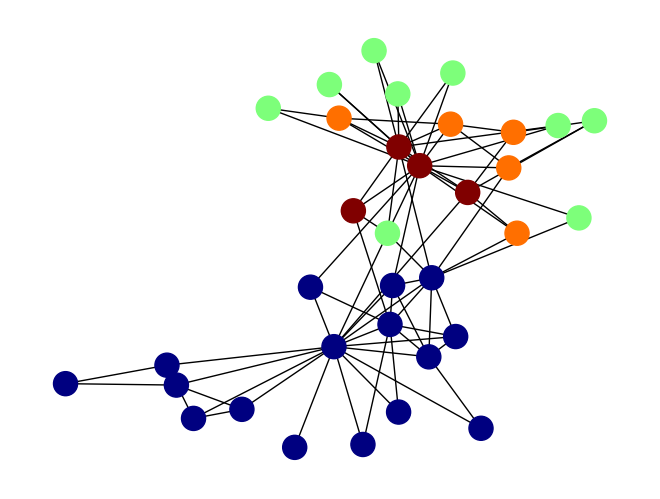

In [51]:
g = nx.read_graphml('karate.GraphML')

plt.figure()
nx.draw(g, cmap=plt.get_cmap('jet'),
    node_color=np.log(list(nx.get_node_attributes(g, 'Faction').values())))
plt.show()

In [ ]:
np.log(list(nx.get_node_attributes(g, 'Faction').values()))

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.69314718, 0.69314718,
       0.        , 0.        , 0.        , 0.        , 0.69314718,
       0.69314718, 0.        , 0.        , 0.69314718, 0.        ,
       0.69314718, 0.        , 0.69314718, 1.09861229, 0.69314718,
       1.09861229, 0.69314718, 1.09861229, 1.09861229, 1.09861229,
       1.38629436, 1.38629436, 1.38629436, 1.38629436])

In [ ]:
# Get important parameters of adjacency matrix
adj = nx.adjacency_matrix(g)

In [ ]:
n_nodes = adj.shape[0]
n_nodes

34

## Preprocessing

In [ ]:
adj_tilde = adj + np.identity(n=adj.shape[0], dtype=np.float32)
print(adj_tilde)
numpy_adj=adj_tilde-np.identity(n=adj.shape[0], dtype=np.float32)

[[1. 4. 5. ... 2. 0. 0.]
 [4. 1. 6. ... 0. 0. 0.]
 [5. 6. 1. ... 0. 2. 0.]
 ...
 [2. 0. 0. ... 1. 4. 4.]
 [0. 0. 2. ... 4. 1. 5.]
 [0. 0. 0. ... 4. 5. 1.]]


In [ ]:
print(numpy_adj.shape)

(34, 34)


In [ ]:
d_tilde_diag = np.squeeze(np.sum(np.array(adj_tilde), axis=1))
print(d_tilde_diag)

[43. 30. 34. 19.  9. 15. 14. 14. 18.  4.  9.  4.  5. 18.  6.  8.  7.  4.
  4.  6.  5.  5.  6. 22.  8. 15.  7. 14.  7. 14. 12. 22. 39. 49.]


In [ ]:
d_tilde_inv_sqrt_diag = np.power(d_tilde_diag, -1/2, dtype=np.float32)
print(d_tilde_inv_sqrt_diag)

[0.15249857 0.18257418 0.17149858 0.22941573 0.33333334 0.2581989
 0.26726124 0.26726124 0.23570226 0.5        0.33333334 0.5
 0.4472136  0.23570226 0.4082483  0.35355338 0.37796447 0.5
 0.5        0.4082483  0.4472136  0.4472136  0.4082483  0.21320072
 0.35355338 0.2581989  0.37796447 0.26726124 0.37796447 0.26726124
 0.28867513 0.21320072 0.16012815 0.14285715]


In [ ]:
d_tilde_inv_sqrt = np.diag(d_tilde_inv_sqrt_diag)
print(d_tilde_inv_sqrt)

[[0.15249857 0.         0.         ... 0.         0.         0.        ]
 [0.         0.18257418 0.         ... 0.         0.         0.        ]
 [0.         0.         0.17149858 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.21320072 0.         0.        ]
 [0.         0.         0.         ... 0.         0.16012815 0.        ]
 [0.         0.         0.         ... 0.         0.         0.14285715]]


In [ ]:
adj_norm = np.dot(np.dot(d_tilde_inv_sqrt, adj_tilde), d_tilde_inv_sqrt)
adj_norm=adj_norm.astype(np.float32)
print(adj_norm)

[[0.02325581 0.11136921 0.13076645 ... 0.06502561 0.         0.        ]
 [0.11136921 0.03333333 0.18786728 ... 0.         0.         0.        ]
 [0.13076645 0.18786728 0.02941176 ... 0.         0.0549235  0.        ]
 ...
 [0.06502561 0.         0.         ... 0.04545455 0.13655774 0.12182899]
 [0.         0.         0.0549235  ... 0.13655774 0.02564102 0.11437725]
 [0.         0.         0.         ... 0.12182899 0.11437725 0.02040816]]


### Features are just the identity matrix

In [ ]:
feat_x = np.identity(n=adj.shape[0])
print(feat_x.shape[-1])

34


In [ ]:
# Semi-supervised
memberships = [m - 1 for m in nx.get_node_attributes(g, 'Faction').values()]

nb_classes = len(set(memberships))
targets = np.array([memberships], dtype=np.int32).reshape(-1)
one_hot_targets = np.eye(4)[targets]

# Pick 3 from each class
labels_to_keep=[17,2,3,  4,6,5,  15,9,20,  27,24,31]

y_train = np.zeros(shape=one_hot_targets.shape,
                   dtype=np.float32)
y_test = one_hot_targets.copy()

train_mask = np.zeros(shape=(n_nodes,), dtype=np.bool)
test_mask = np.ones(shape=(n_nodes,), dtype=np.bool)

for l in labels_to_keep:
    y_train[l, :] = one_hot_targets[l, :]
    y_test[l, :] = np.zeros(shape=(nb_classes,))
    train_mask[l] = True
    test_mask[l] = False

#GNN Pytorch model

In [2]:
# Install torch geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.6 MB/s eta 0:00:00


In [3]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_scatter_cuda.so: undefined symbol: _ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_St8optionalIN3c1017basic_string_viewIcEEE
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_spmm_cuda.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [4]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {(data.num_edges) / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


We can see that this data object holds 4 attributes: (1) The edge_index property holds the information about the graph connectivity, i.e., a tuple of source and destination node indices for each edge. PyG further refers to (2) node features as x (each of the 34 nodes is assigned a 34-dim feature vector), and to (3) node labels as y (each node is assigned to exactly one class). (4) There also exists an additional attribute called train_mask, which describes for which nodes we already know their community assigments. In total, we are only aware of the ground-truth labels of 4 nodes (one for each community), and the task is to infer the community assignment for the remaining nodes.

In [14]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)

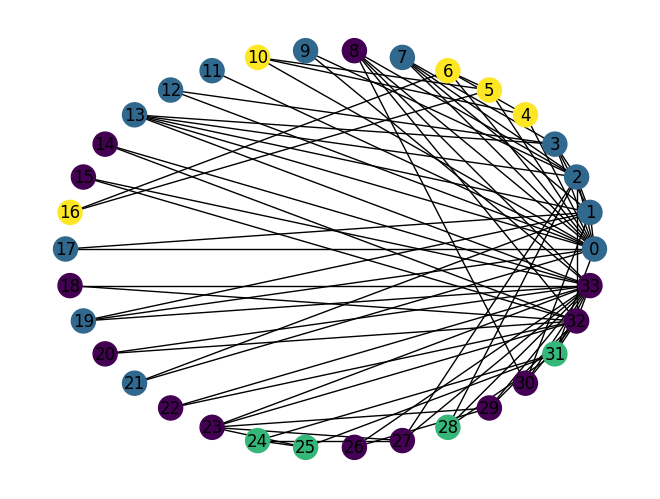

In [15]:

pos = nx.circular_layout(G) # Layout of the graph
nx.draw(G, pos, with_labels=True, node_color=data.y.numpy())


the GCNConv layers reduce the node feature dimensionality to  2 , i.e.,  34→8→4→2 . Each GCNConv layer is enhanced by a tanh non-linearity.

In [8]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class PyGCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 8)
        self.conv2 = GCNConv(8, 8)
        self.conv3 = GCNConv(8, 4)
        self.conv4 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()
        h = self.conv4(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = PyGCN()
print(model)

PyGCN(
  (conv1): GCNConv(34, 8)
  (conv2): GCNConv(8, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


In [17]:
def visualize(h, color, epoch=None, loss=None, accuracy=None, node_labels=False):
    #plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        # Handle PyTorch tensor case (embeddings)
        h = h.detach().cpu().numpy()
        scatter = plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")

        # Add node numbers if requested
        if node_labels:
            for i, (x, y) in enumerate(h):
                plt.text(x, y, str(i), fontsize=8, ha='center', va='center')

        if epoch is not None and loss is not None and accuracy['train'] is not None and accuracy['val'] is not None:
            plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f} \n'
                      f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                      f'Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                      fontsize=16)
    else:
        # Handle NetworkX graph case
        pos = nx.spring_layout(h, seed=42)
        nx.draw_networkx(h, pos=pos, with_labels=False,
                       node_color=color, cmap="Set2")

        # Add node numbers if requested
        if node_labels:
            for node, (x, y) in pos.items():
                plt.text(x, y, str(node), fontsize=8, ha='center', va='center')

    #plt.show()

In [23]:
# Example usage with the Karate Club dataset:
model = PyGCN()
_, h = model(data.x, data.edge_index)

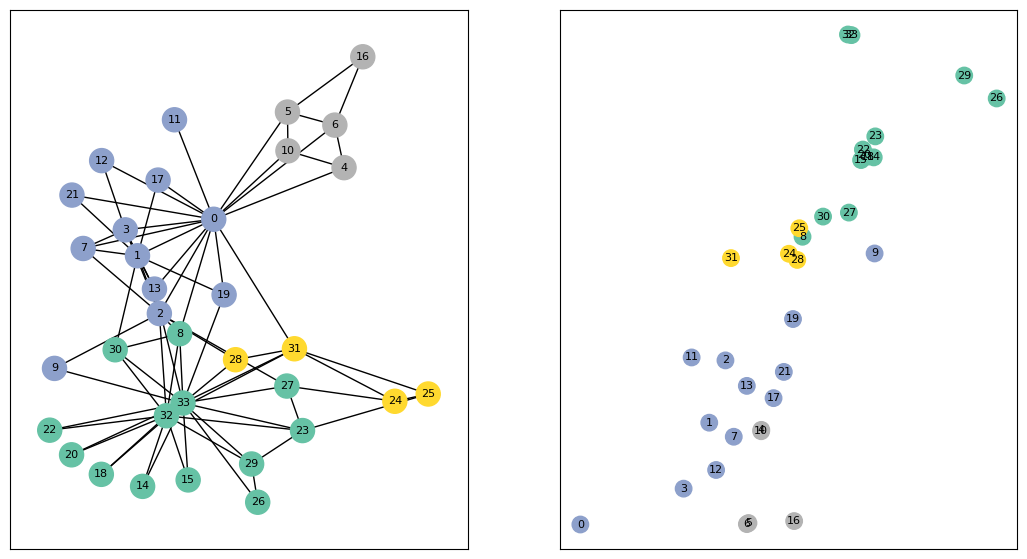

In [29]:
# You can also visualize the original graph with node numbers
plt.figure(figsize=(13,7))
figure = plt.subplot(1,2,1)
visualize(G, color=data.y.numpy(), node_labels=True)

figure = plt.subplot(1,2,2)
# Visualize with node numbers
visualize(h, color=data.y, node_labels=True)

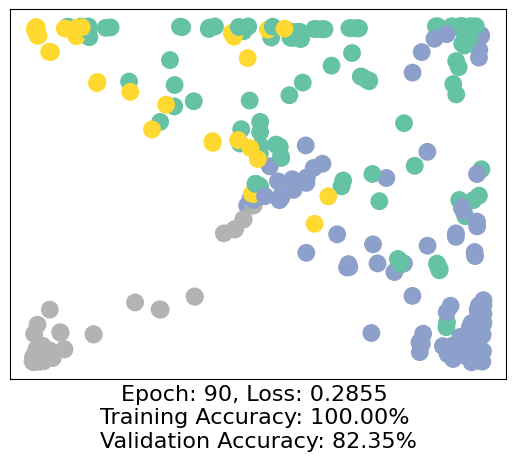

In [30]:
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.

    accuracy = {}
    # Calculate training accuracy on our four examples
    predicted_classes = torch.argmax(out[data.train_mask], axis=1) # [0.6, 0.2, 0.7, 0.1] -> 2
    target_classes = data.y[data.train_mask]
    accuracy['train'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    # Calculate validation accuracy on the whole graph
    predicted_classes = torch.argmax(out, axis=1)
    target_classes = data.y
    accuracy['val'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    return loss, h, accuracy

for epoch in range(100):
    loss, h, accuracy = train(data)
    # Visualize the node embeddings every 10 epochs
    if epoch % 10 == 0:
        visualize(h, color=data.y, epoch=epoch, loss=loss, accuracy=accuracy)

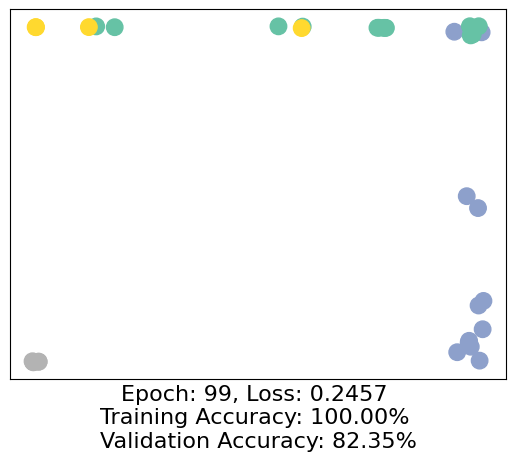

In [31]:
visualize(h, color=data.y, epoch=epoch, loss=loss, accuracy=accuracy)

# GNN Class Tensorflow new version

The equation of graph convolution is as below. <br>
$$ H^{l+1} = \sigma(AH^{l}W^{l}) $$
We will implement this equation in function named graph_conv. The function will receive l-th node features,  adjacency matrix, and the output dimension of node features as inputs.

Actually, original equation is introduced as above, which does not use bias term, in T.Kipf's paper. However, I think using bias is necessary, as below, because the bias term shifts the decision boundary.
$$ H^{l+1} = \sigma(A(H^{l}W^{l}+b^{l})) $$
Therefore, I set 'use_bias=True' at a dense layer in the graph convolution.

In [60]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
from sklearn.manifold import TSNE # Import t-SNE for dimensionality reduction

In [45]:
n_nodes = G.number_of_nodes()
print(f"Number of nodes: {n_nodes}")

# Ensure 'Faction' attribute exists, which is typically present in this dataset.
# If not, you might need to run community detection or assign dummy factions.
#if 'Faction' not in next(iter(G.nodes(data=True)))[1]:
#    print("Warning: 'Faction' attribute not found in graph nodes. Assigning dummy factions.")
#    # For Karate Club, often 2 factions are detected. Assigning a simple modulo based on node ID.
#    for i, node_id in enumerate(G.nodes()):
#        G.nodes[node_id]['Faction'] = (i % 2) + 1
#else:
#    print("Found 'Faction' attribute.")


# --- 2. Feature Matrix (feat_x) ---
# For the Karate Club graph, an identity matrix is a common choice when no other
# explicit node features are available. Each node is uniquely identified by a one-hot vector.
f_dimension = n_nodes # Using identity matrix as features
feat_x = np.eye(n_nodes).astype(np.float32)
print(f"Feature matrix shape: {feat_x.shape}")


# --- 3. Adjacency Matrix Preparation ---
# Get the adjacency matrix from the NetworkX graph.
adj = nx.adjacency_matrix(G).astype(np.float32)

# Normalize the adjacency matrix using the symmetric normalization for GCNs:
# A_hat = D_tilde^(-1/2) * A_tilde * D_tilde^(-1/2)
# where A_tilde = A + I (A with self-loops).
adj_tilde = adj + np.eye(n_nodes) # Add self-loops
rowsum = np.array(adj_tilde.sum(1))
d_inv_sqrt = np.power(rowsum, -0.5).flatten()
d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0. # Handle nodes with no connections (isolated nodes)
d_mat_inv_sqrt = np.diag(d_inv_sqrt)
adj_norm = d_mat_inv_sqrt.dot(adj_tilde).dot(d_mat_inv_sqrt) # Correct order of multiplication
#adj_norm = adj_norm.todense() # Convert to dense array for TensorFlow operations


# --- 4. Semi-supervised Data Preparation ---
# Map faction labels to 0-indexed integers.
#memberships = [m - 1 for m in nx.get_node_attributes(g, 'Faction').values()]
memberships = data.y.numpy()

nb_classes = len(set(memberships))
targets = np.array(memberships, dtype=np.int32).reshape(-1)
one_hot_targets = np.eye(nb_classes)[targets]
print(f"Number of classes (factions): {nb_classes}")
print(f"One-hot targets shape: {one_hot_targets.shape}")

y_train = np.zeros(shape=one_hot_targets.shape, dtype=np.float32)
y_test = one_hot_targets.copy()

train_mask = np.zeros(shape=(n_nodes,), dtype=bool)
test_mask = np.ones(shape=(n_nodes,), dtype=bool)

# Dynamically select 3 nodes from each class for training.
# This ensures robustness even if class distribution or node count changes slightly.
labels_to_keep = []
nodes_per_class = {i: [] for i in range(nb_classes)}
for i, member_id in enumerate(memberships):
    nodes_per_class[member_id].append(i)

num_samples_per_class = 3 # As per your requirement: pick 3 from each class
for class_id in range(nb_classes):
    class_nodes = nodes_per_class[class_id]
    # Sample nodes, ensuring we don't pick more than available in the class.
    # `replace=False` means no duplicate nodes are picked from the same class.
    sampled_nodes = np.random.choice(class_nodes, min(len(class_nodes), num_samples_per_class), replace=False)
    labels_to_keep.extend(sampled_nodes.tolist())

print(f"Nodes selected for training (labels_to_keep): {labels_to_keep}")

# Apply the semi-supervised mask.
for node_idx in labels_to_keep:
    y_train[node_idx, :] = one_hot_targets[node_idx, :] # Keep label for training
    y_test[node_idx, :] = np.zeros(shape=(nb_classes,)) # Mask out label for testing
    train_mask[node_idx] = True # Include in training loss calculation
    test_mask[node_idx] = False # Exclude from test accuracy calculation



Number of nodes: 34
Feature matrix shape: (34, 34)
Number of classes (factions): 4
One-hot targets shape: (34, 4)
Nodes selected for training (labels_to_keep): [8, 26, 18, 3, 7, 17, 25, 31, 28, 6, 16, 5]


## Graph Convolution Network

In [88]:

## GCN Model Definition


class GCN:
    def __init__(self, layer_sizes, n_nodes, f_dimension, nb_classes):
        self.n_nodes = n_nodes
        self.f_dimension = f_dimension
        self.nb_classes = nb_classes
        self.layer_sizes = layer_sizes

        # Define Graph Convolutional Layers
        self.conv_layers = []
        for i, size in enumerate(self.layer_sizes):
            self.conv_layers.append(tf.keras.layers.Dense(units=size, use_bias=True, name=f'gcn_layer_{i}'))

        # Define the final Dense layer for classification output
        self.output_layer = tf.keras.layers.Dense(units=self.nb_classes, activation=None, name='output_layer')

        # NEW: A dedicated layer to project the last GCN layer's output to 2D
        # for visualization purposes. This does *not* affect the classification head.
        self.embedding_projection_layer = tf.keras.layers.Dense(units=2, use_bias=True, name='embedding_projection_layer')


    def graph_conv(self, _X, _A, dense_layer, activation=tf.nn.relu):
        """Performs a single graph convolutional operation."""
        output = dense_layer(_X)  # Apply dense transformation to features
        output = tf.matmul(_A, output)  # Multiply by adjacency matrix
        output = activation(output)  # Apply activation
        return output

    def call(self, X, adj, dropout_rate, is_training):
        """Defines the forward pass of the GCN model."""
        L = X
        # Pass through graph convolutional layers
        for i, conv_layer in enumerate(self.conv_layers):
            L = self.graph_conv(L, adj, conv_layer, activation=tf.nn.relu)
            if is_training:
                L = tf.nn.dropout(L, rate=dropout_rate)

        # 'L' now holds the high-dimensional node embeddings from the last GCN layer.
        # Project these embeddings to 2D for visualization.
        visual_embeddings = self.embedding_projection_layer(L)

        # The classification head uses the original high-dimensional 'L' for its final output.
        hypothesis = self.output_layer(tf.matmul(adj, L))

        # Return both the classification logits and the 2D visual embeddings.
        return hypothesis, visual_embeddings

    def compute_loss(self, y_true, y_pred, mask):
        """Computes the masked softmax cross-entropy loss."""
        # Use from_logits=True for softmax_cross_entropy_with_logits
        cost = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
        mask = tf.cast(mask, dtype=tf.float32)
        # Normalize mask to average the loss correctly over masked elements.
        mask_sum = tf.reduce_sum(mask)
        if mask_sum > 0:
            mask /= mask_sum
        else:
            mask = tf.zeros_like(mask) # Avoid division by zero if mask is empty
        cost *= mask
        return tf.reduce_mean(cost)

    def compile_model(self, lr=0.01, optimizer=tf.optimizers.Adam):
        """Configures the model for training with an optimizer."""
        self.optimizer = optimizer(learning_rate=lr)

    @tf.function # Decorator to compile the function into a TensorFlow graph for performance.
    def train_step(self, X, y_true, mask, adj, dropout_rate):
        """Performs a single training step using GradientTape."""
        with tf.GradientTape() as tape:
            y_pred, _ = self.call(X, adj, dropout_rate, is_training=True)
            loss = self.compute_loss(y_true, y_pred, mask)
        # Compute gradients for all trainable variables.
        gradients = tape.gradient(loss, [
            var for layer in self.conv_layers for var in layer.trainable_variables
        ] + self.output_layer.trainable_variables + self.embedding_projection_layer.trainable_variables)
        # Apply gradients to update model weights.
        self.optimizer.apply_gradients(zip(gradients, [
            var for layer in self.conv_layers for var in layer.trainable_variables
        ] + self.output_layer.trainable_variables + self.embedding_projection_layer.trainable_variables))
        return loss

    def accuracy(self, X, Y, mask, adj):
        """Calculates accuracy with masking."""
        # Run forward pass without dropout for evaluation.
        preds, visual_embeddings = self.call(X, adj, dropout_rate=0.0, is_training=False)

        # Convert logits to class predictions.
        predicted_labels = tf.argmax(preds, axis=1)
        true_labels = tf.argmax(Y, axis=1)

        correct_prediction = tf.equal(predicted_labels, true_labels)
        accuracy_all = tf.cast(correct_prediction, tf.float32)

        mask = tf.cast(mask, dtype=tf.float32)
        mask_sum = tf.reduce_sum(mask)
        if mask_sum > 0:
            mask /= mask_sum # Normalize mask for correct averaging
        else:
            mask = tf.zeros_like(mask)

        accuracy_all *= mask
        # Return accuracy as a scalar NumPy value and the 2D embeddings.
        return tf.reduce_sum(accuracy_all).numpy(), visual_embeddings.numpy()

    def draw(self, g, outputs, node_labels=None):
        """
        Draws the graph embeddings at different epochs, assuming embeddings are already 2D.

        Args:
            g (networkx.Graph): The graph to draw.
            outputs (dict): A dictionary where keys are epoch numbers and values
                            are the node embeddings (numpy array) at that epoch,
                            which are expected to be 2D (N, 2).
            node_labels (dict, optional): A dictionary mapping node IDs to their labels
                                          for coloring. Defaults to None.
        """
        # Ensure outputs are sorted by epoch for consistent plotting order.
        epochs_to_plot = sorted(list(outputs.keys()))

        node_positions = {}
        for epoch in epochs_to_plot:
            embeddings_2d = outputs[epoch] # Directly use the 2D embeddings provided by the model.

            # Basic check to ensure the embeddings are indeed 2D.
            if embeddings_2d.shape[1] != 2:
                print(f"Error: Embeddings for epoch {epoch} are not 2D. Shape: {embeddings_2d.shape}")
                print("Please ensure your GCN model's `embedding_projection_layer` is configured to output 2D embeddings.")
                continue # Skip plotting for this epoch if dimensions are incorrect.

            # Map the 2D embeddings to node positions for NetworkX drawing.
            # It's crucial that the order of `embeddings_2d` matches the order of `nx.nodes(g)`.
            node_positions[epoch] = {node_id: embeddings_2d[i]
                                     for i, node_id in enumerate(nx.nodes(g))}

        plot_titles = {o: f'Epoch {o}' for o in node_positions.keys()}

        num_plots = len(node_positions)
        if num_plots == 0:
            print("No valid embeddings to plot. Check `outputs` dictionary and embedding dimensions.")
            return

        # Determine grid dimensions for subplots.
        nrows = int(np.ceil(num_plots / 3))
        ncols = min(num_plots, 3)

        f, axes = plt.subplots(nrows=nrows, ncols=ncols, sharey=True, sharex=True, figsize=(5 * ncols, 5 * nrows))

        # Handle the case of a single subplot (axes would not be an array).
        if num_plots == 1:
            axes = np.array([axes])

        epochs_to_plot_successful = sorted(list(node_positions.keys()))

        for i, ax in enumerate(axes.flat):
            if i < num_plots:
                epoch = epochs_to_plot_successful[i]
                pos = node_positions[epoch]
                ax.set_title(plot_titles[epoch])

                node_colors = None
                # Prioritize 'node_labels' if provided, otherwise use 'Faction' attribute from graph.

                unique_labels = np.unique(node_labels)
                label_to_int = {label: i for i, label in enumerate(unique_labels)}
                node_colors = [label_to_int[node_labels[n]] for n in nx.nodes(G)]

                nx.draw(
                    g,
                    cmap=plt.get_cmap('jet'),
                    node_color=node_colors,
                    pos=pos, # Use the 2D positions directly
                    ax=ax,
                    node_size=100,
                    alpha=0.8
                )
            else:
                f.delaxes(ax) # Hide empty subplots if num_plots is not a multiple of ncols.

        plt.tight_layout()
        plt.show()



Starting GCN training...


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['embedding_projection_layer/kernel', 'embedding_projection_layer/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch: 0010, cost=0.03838, train_acc: 0.8333, test_acc: 0.7727
Epoch: 0020, cost=0.03389, train_acc: 0.7500, test_acc: 0.7273
Epoch: 0030, cost=0.02736, train_acc: 0.9167, test_acc: 0.7727
Epoch: 0040, cost=0.02413, train_acc: 1.0000, test_acc: 0.9091
Epoch: 0050, cost=0.01696, train_acc: 0.9167, test_acc: 0.7273
Epoch: 0060, cost=0.01495, train_acc: 1.0000, test_acc: 0.8636
Epoch: 0070, cost=0.00920, train_acc: 1.0000, test_acc: 0.8636
Epoch: 0080, cost=0.00889, train_acc: 1.0000, test_acc: 0.9091
Epoch: 0090, cost=0.01208, train_acc: 1.0000, test_acc: 0.8182
Epoch: 0100, cost=0.01300, train_acc: 1.0000, test_acc: 0.8636
Epoch: 0110, cost=0.00466, train_acc: 1.0000, test_acc: 0.9091
Epoch: 0120, cost=0.00708, train_acc: 1.0000, test_acc: 0.8182
Epoch: 0130, cost=0.00806, train_acc: 1.0000, test_acc: 0.8182
Epoch: 0140, cost=0.01073, train_acc: 1.0000, test_acc: 0.8636
Epoch: 0150, cost=0.00405, train_acc: 1.0000, test_acc: 0.8636
Epoch: 0160, cost=0.00632, train_acc: 1.0000, test_acc:

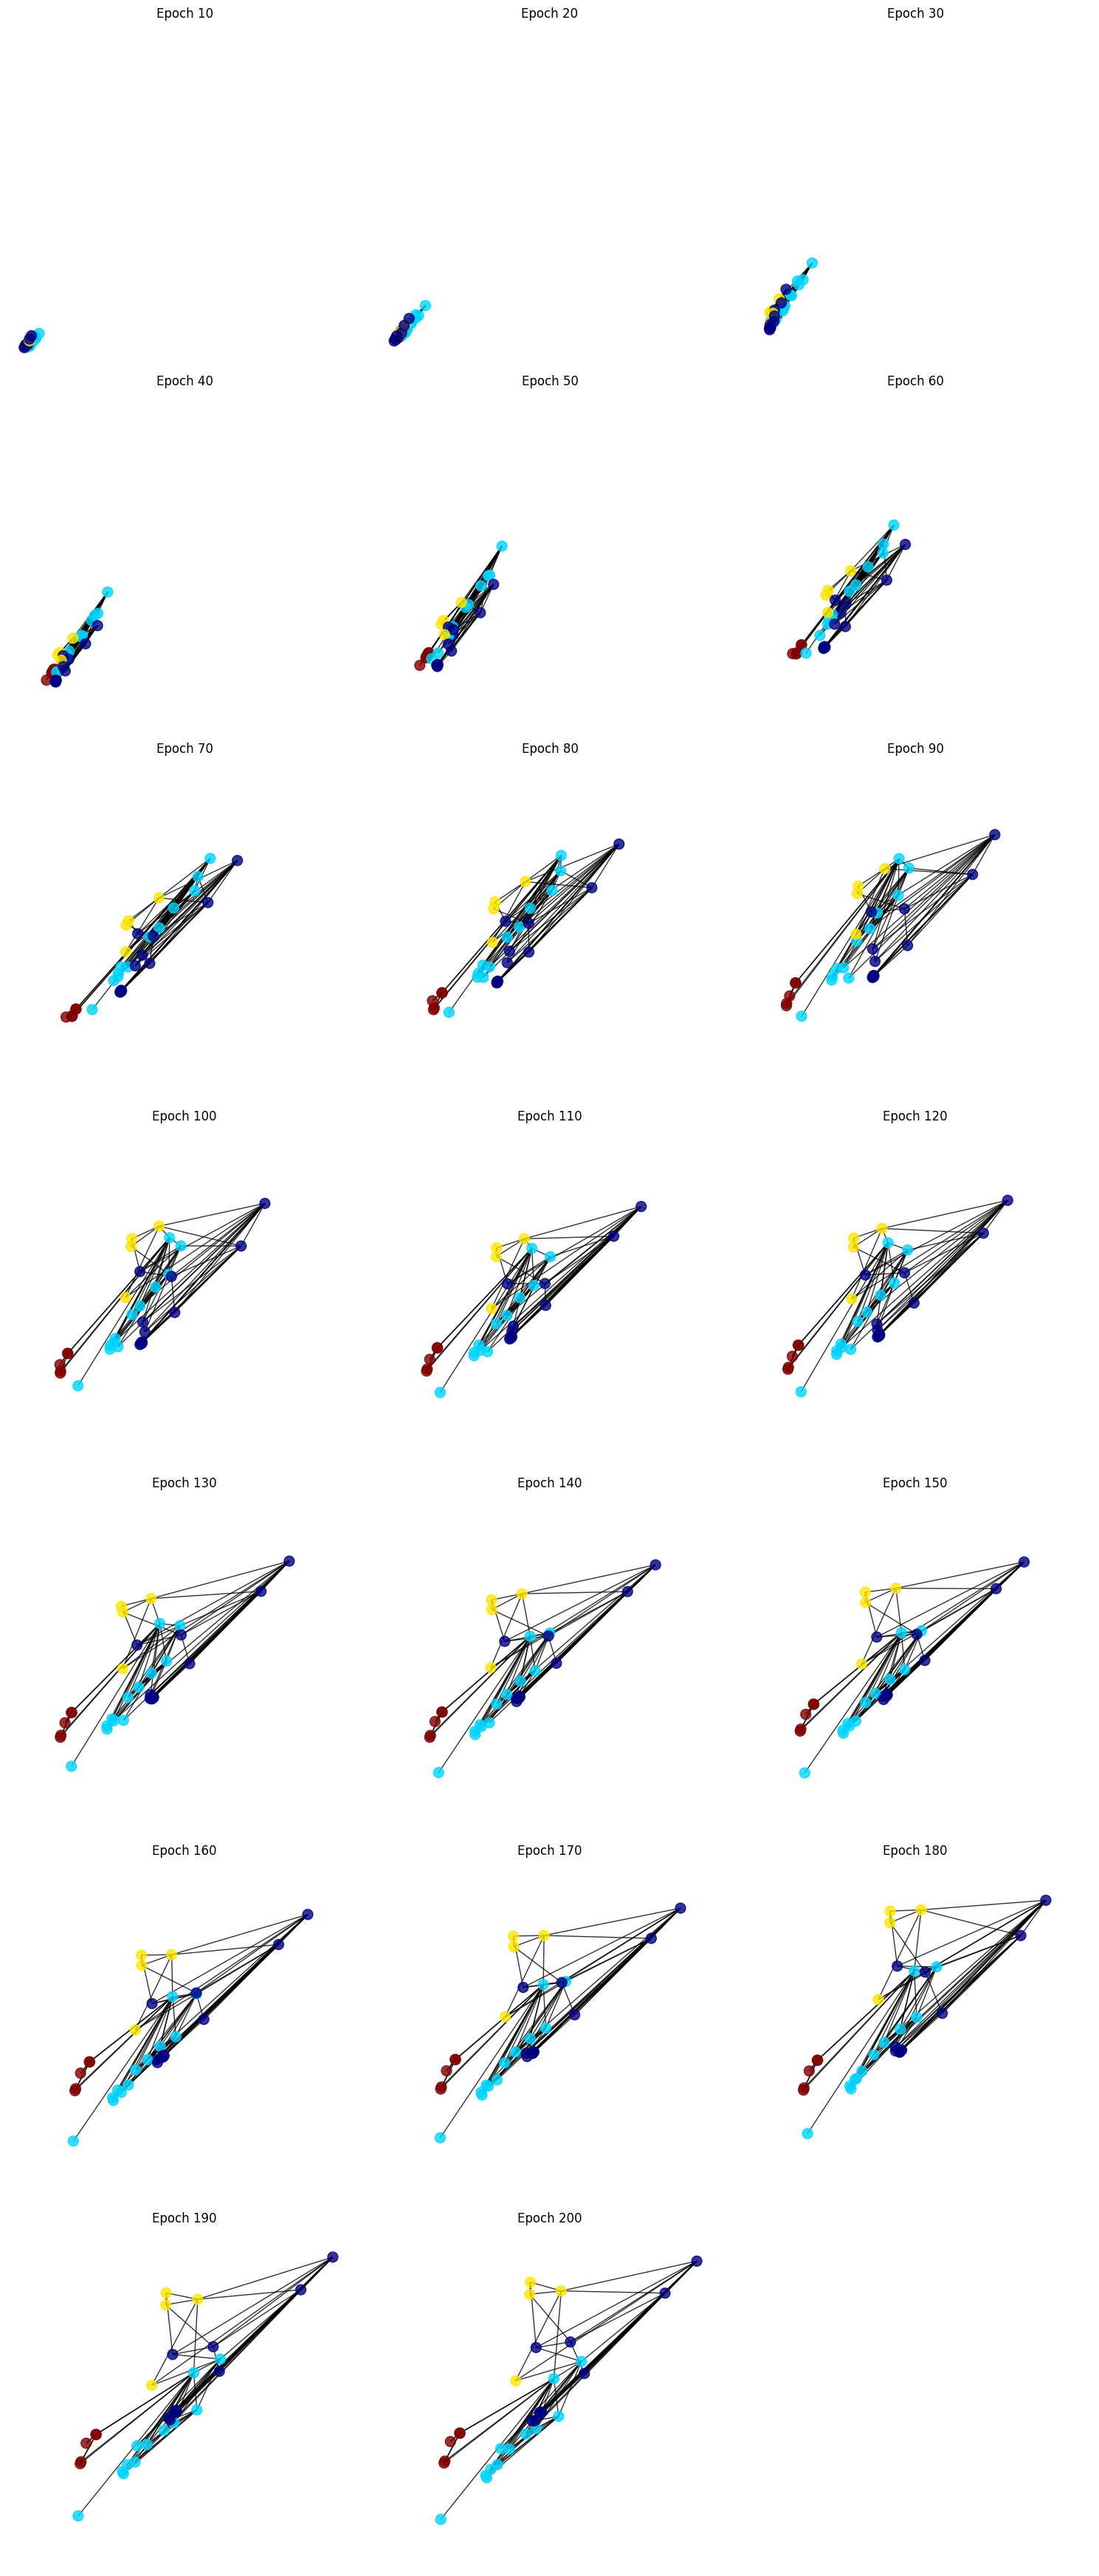


Training and visualization complete.


In [89]:
# --- Model Initialization ---
# Define the architecture of your GCN's convolutional layers.
# Note: The last layer in `layer_sizes` determines the dimensionality of the *input*
# to the `embedding_projection_layer` and `output_layer`.
# For 2D visualization, we added a separate `embedding_projection_layer` that handles
# the reduction to 2 dimensions. So `layer_sizes` can be any reasonable values.
layer_sizes = [16, 8] # Example: two GCN layers with 16 and 8 output features.

model = GCN(layer_sizes, n_nodes, f_dimension, nb_classes)
model.compile_model(lr=0.01) # Set the learning rate for the Adam optimizer.

# --- Training and Evaluation Loop ---
outputs = {} # To store 2D node embeddings for visualization at different epochs.
test_outputs = {} # Can be used to store test metrics or embeddings if needed.

epochs = 200 # Total number of training epochs.
dropout_rate = 0.5 # Dropout rate applied during training.

# Convert all NumPy arrays to TensorFlow Tensors once before the loop for efficiency.
feat_x_tf = tf.constant(feat_x, dtype=tf.float32)
y_train_tf = tf.constant(y_train, dtype=tf.float32)
y_test_tf = tf.constant(y_test, dtype=tf.float32)
train_mask_tf = tf.constant(train_mask, dtype=tf.float32)
test_mask_tf = tf.constant(test_mask, dtype=tf.float32)
adj_norm_tf = tf.constant(adj_norm, dtype=tf.float32)


print("\nStarting GCN training...")
for epoch in range(epochs):
    # Perform a single training step.
    avg_cost = model.train_step(
        X=feat_x_tf,
        y_true=y_train_tf,
        mask=train_mask_tf,
        adj=adj_norm_tf,
        dropout_rate=dropout_rate
    ).numpy() # Get the NumPy scalar value of the loss.

    # Evaluate accuracy on training and test sets.
    train_acc, node_embeddings_2d_train = model.accuracy(
        X=feat_x_tf,
        Y=y_train_tf,
        mask=train_mask_tf,
        adj=adj_norm_tf
    )

    # Store the 2D node embeddings for visualization.
    # Store at specific intervals (e.g., every 10 epochs) and the very last epoch.
    if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
        outputs[epoch + 1] = node_embeddings_2d_train # Key is epoch number.

    test_acc, _ = model.accuracy( # We don't need test embeddings for drawing here.
        X=feat_x_tf,
        Y=y_test_tf,
        mask=test_mask_tf,
        adj=adj_norm_tf
    )

    # Print progress during training.
    if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
        print(f'Epoch: {epoch + 1:04d}, '
              f'cost={avg_cost:.5f}, '
              f'train_acc: {train_acc:.4f}, '
              f'test_acc: {test_acc:.4f}')

# --- Visualization ---
# Pass the original 'Faction' memberships to the draw function for coloring nodes.
#node_labels_for_drawing = nx.get_node_attributes(g, 'Faction')
node_labels_for_drawing = data.y.numpy()
model.draw(G, outputs, node_labels=node_labels_for_drawing)

print("\nTraining and visualization complete.")

## Graph attention network(GAT)

Attention mechanism revisits us. <br>
In natural language processing, the attention mechanisms - local and global - find the relationship between the words and give scores.

We can apply the attention in graph convolution network as well. <br>
A node embedding in GCN is

$$ H_i^{(l)} = \sigma( \sum_{j \in N(i)} H_j^{(l)}W^{(l)} )$$

GCN considers the adjacent nodes and itself with equal weights in updating node states.<br>
However, it is more natural that the importance of each node is different, and the importance can be obtained by learning the relationship between node states.

With attention coefficient, the node embedding can be rewritten as follow.

$$ H_i^{(l+1)} = \sigma( \sum_{j \in N(i)} \alpha_{ij}^{(l)} H_j^{(l)}W^{(l)} ) $$
$$ \alpha_{ij}^{(l)} = f(H_i^{(l)}W^{(l)}, H_j^{(l)}W^{(l)}) $$

There are various approaches to obtain the attention coefficient, $\alpha_{ij}$, and three approaches are introduced in the following reference:
* Luong, Minh-Thang, Hieu Pham, and Christopher D. Manning. "Effective approaches to attention-based neural machine translation." arXiv preprint arXiv:1508.04025 (2015).

In the paper "Graph attention networks", authors represent the attention coefficient by concatenation.
* Velickovic, Petar, et al. "Graph attention networks." arXiv preprint arXiv:1710.10903 (2017).

$$ \alpha_{ij} = softmax(e_{ij}) = \frac{e_{ij}}{\sum_{k \in N(i)} e_{ik}} $$
$$ e_{ij} = f(H_iW, H_jW) = \tau(a^T (H_iW||H_jW))$$

Normalizing the coefficient with softmax activation isn't proper for molecular applications, however, we recommend $e_{ij}$ term only for the case. <br>
We use a general form of the attention in our works which investigate molecular structure property relationship using the graph attention network.


In [94]:
class GAT:
    def __init__(self, layer_sizes, n_nodes, f_dimension, nb_classes, num_heads=8):
        """
        Initializes the GAT model.

        Args:
            layer_sizes (list): List of integers, output dimensions for attention layers.
                                 Note: For GAT, often the first layer uses num_heads * output_dim.
                                 The last layer usually outputs the final embedding dimension.
            n_nodes (int): Number of nodes in the graph.
            f_dimension (int): Dimension of input features per node.
            nb_classes (int): Number of output classes.
            num_heads (int): Number of attention heads for each GAT layer.
        """
        self.n_nodes = n_nodes
        self.f_dimension = f_dimension
        self.nb_classes = nb_classes
        self.layer_sizes = layer_sizes
        self.num_heads = num_heads

        self.attn_layers = []
        # Each GAT layer has a list of attention heads.
        # The original code's `for k in range(8): X_k = tf.layers.dense(self.hidden_layer, 8, use_bias=True)`
        # suggests each head processes input to 8 dimensions, then concatenated.
        # So, if layer_sizes = [16, 8], it means:
        # Layer 1: output_dim=16, num_heads=8 => each head outputs 16/8 = 2 features per head. Total 16 features.
        # Layer 2: output_dim=8, num_heads=1 (often just one head for final layer) => 8 features.

        # For simplicity, we'll make each head in the first layers output `layer_size // num_heads` features
        # and then concatenate them. The last GAT layer will output the final embedding dimension.

        # A list to hold the trainable Dense layers for the attention mechanism
        self.f1_layers = [] # For attention calculation (f_1 * W)
        self.f2_layers = [] # For attention calculation (f_2 * W)
        self.dense_attn_layers = [] # For the initial linear transformation (X * W_k)

        for i, size in enumerate(self.layer_sizes):
            # Each head applies a linear transformation (like tf.layers.dense)
            # The output of each head is `size // num_heads`
            output_per_head = size // self.num_heads if i < len(self.layer_sizes) - 1 else size # Last layer might not split

            # These are the linear layers applied to input X for each head
            head_denses = [tf.keras.layers.Dense(units=output_per_head, use_bias=False, name=f'gat_dense_{i}_head_{h}')
                           for h in range(self.num_heads)]
            self.dense_attn_layers.append(head_denses)

            # These are the attention weight vectors a_1 and a_2 (e.g., `a_1 * W`)
            f1_heads = [tf.keras.layers.Conv1D(filters=1, kernel_size=1, use_bias=False, name=f'attn_f1_{i}_head_{h}')
                        for h in range(self.num_heads)]
            self.f1_layers.append(f1_heads)

            f2_heads = [tf.keras.layers.Conv1D(filters=1, kernel_size=1, use_bias=False, name=f'attn_f2_{i}_head_{h}')
                        for h in range(self.num_heads)]
            self.f2_layers.append(f2_heads)

        # The output dense layer for classification
        self.output_layer = tf.keras.layers.Dense(units=self.nb_classes, activation=None, name='output_layer')

        # Layer for projecting the final node embeddings to 2D for visualization
        self.embedding_projection_layer = tf.keras.layers.Dense(units=2, use_bias=True, name='embedding_projection_layer')


    def attn_coeffs(self, X_input, adj, head_idx, layer_idx, dropout_rate=0.0):
        """
        Calculates attention coefficients for a single head.

        Args:
            X_input (tf.Tensor): Input features to the attention mechanism.
                                 Shape: (batch_size, n_nodes, features_per_head)
            adj (tf.Tensor): Adjacency matrix. Shape: (batch_size, n_nodes, n_nodes)
            head_idx (int): Index of the current attention head.
            layer_idx (int): Index of the current GAT layer.
            dropout_rate (float): Dropout rate for attention coefficients.

        Returns:
            tf.Tensor: Attention coefficients matrix. Shape: (batch_size, n_nodes, n_nodes)
        """
        # Apply linear transformation (X * W_k) for the current head
        X_k = self.dense_attn_layers[layer_idx][head_idx](X_input) # (batch_size, n_nodes, features_per_head)

        # Apply Conv1D to get f_1 and f_2 components (a_1 * W and a_2 * W)
        f_1 = self.f1_layers[layer_idx][head_idx](X_k) # (batch_size, n_nodes, 1)
        f_2 = self.f2_layers[layer_idx][head_idx](X_k) # (batch_size, n_nodes, 1)

        # Calculate logits (e_ij = LeakyReLU(a_vec * [W_k * x_i || W_k * x_j]))
        # This is (f_1_i + f_2_j^T)
        logits = f_1 + tf.transpose(f_2, perm=[0, 2, 1]) # (batch_size, n_nodes, n_nodes)

        # Apply Leaky ReLU as per original GAT formulation
        logits = tf.nn.leaky_relu(logits, alpha=0.2) # alpha=0.2 is common for LeakyReLU in GAT

        # Mask attention coefficients based on adjacency matrix
        # Non-connected nodes get a very small negative value before softmax
        zero_vec = -9e15 * tf.ones_like(logits)
        attention_masked = tf.where(adj > 0, logits, zero_vec) # Masking by adjacency

        # Apply softmax to get attention coefficients (alpha_ij)
        coefs = tf.nn.softmax(attention_masked, axis=2)

        # Apply dropout to attention coefficients (often done in GAT)
        coefs = tf.nn.dropout(coefs, rate=dropout_rate)
        return coefs

    def call(self, X, adj, dropout_rate, is_training):
        """Defines the forward pass of the GAT model."""
        hidden_layer = X # Initial input features

        for layer_idx, layer_size in enumerate(self.layer_sizes):
            head_outputs = []
            current_num_heads = self.num_heads if layer_idx < len(self.layer_sizes) - 1 else 1 # Last layer often uses 1 head

            for head_idx in range(current_num_heads):
                # Calculate attention coefficients for each head
                attn_matrix = self.attn_coeffs(hidden_layer, adj, head_idx, layer_idx,
                                               dropout_rate=dropout_rate if is_training else 0.0)

                # Apply the attention matrix to the linearly transformed features
                # (alpha_ij * W_k * x_j)
                transformed_features_for_head = self.dense_attn_layers[layer_idx][head_idx](hidden_layer)
                attended_features = tf.matmul(attn_matrix, transformed_features_for_head)
                head_outputs.append(attended_features)

            # Concatenate or average attention heads
            if layer_idx < len(self.layer_sizes) - 1:
                hidden_layer = tf.concat(head_outputs, axis=-1) # Concatenate for intermediate layers
                if is_training:
                    hidden_layer = tf.nn.dropout(hidden_layer, rate=dropout_rate)
                hidden_layer = tf.nn.relu(hidden_layer) # Apply activation after concatenation
            else:
                # For the last GAT layer, usually average attention heads (or just use one)
                # The original code's final output was passed through a dense layer,
                # then ReLU, then another dense layer.
                hidden_layer = head_outputs[0] if current_num_heads == 1 else tf.reduce_mean(tf.stack(head_outputs, axis=0), axis=0)
                if is_training:
                    hidden_layer = tf.nn.dropout(hidden_layer, rate=dropout_rate) # Dropout after last GAT layer
                hidden_layer = tf.nn.relu(hidden_layer) # Apply activation after final GAT layer


        # hidden_layer here is the final, high-dimensional node embedding from the GAT block.
        final_node_embeddings = hidden_layer

        # Project high-dimensional embeddings to 2D for visualization
        visual_embeddings = self.embedding_projection_layer(final_node_embeddings)

        # Final hypothesis layer for classification
        hypothesis = self.output_layer(final_node_embeddings) # The output layer uses the actual GAT embeddings

        return hypothesis, visual_embeddings

    def compute_loss(self, y_true, y_pred, mask):
        """Computes the masked softmax cross-entropy loss."""
        # Ensure y_true and y_pred have batch dimensions for `softmax_cross_entropy_with_logits`
        # (batch_size, n_nodes, nb_classes)
        cost = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)

        # Mask now has shape (batch_size, n_nodes)
        mask = tf.cast(mask, dtype=tf.float32)

        # Reshape mask to (batch_size, n_nodes, 1) to broadcast correctly
        mask_reshaped = tf.expand_dims(mask, axis=-1)

        cost *= mask_reshaped

        # Only average over the masked nodes, not the batch dimension if you want total loss per batch.
        # Or, sum over nodes and then average over batch:
        masked_cost_sum_nodes = tf.reduce_sum(cost, axis=[1, 2]) # Sum over n_nodes and nb_classes

        # Normalize by the number of active nodes in the mask, across the batch
        num_active_nodes = tf.reduce_sum(mask, axis=1) # (batch_size,)

        # Avoid division by zero
        num_active_nodes = tf.where(num_active_nodes == 0, tf.ones_like(num_active_nodes), num_active_nodes)

        # Average loss per batch sample, only considering active nodes
        per_sample_loss = masked_cost_sum_nodes / num_active_nodes

        return tf.reduce_mean(per_sample_loss) # Average across the batch


    def compile_model(self, lr=0.01, optimizer=tf.optimizers.Adam):
        """Configures the model for training with an optimizer."""
        self.optimizer = optimizer(learning_rate=lr)

    @tf.function
    def train_step(self, X, y_true, mask, adj, dropout_rate):
        """Performs a single training step."""
        with tf.GradientTape() as tape:
            y_pred, _ = self.call(X, adj, dropout_rate, is_training=True)
            loss = self.compute_loss(y_true, y_pred, mask)

        trainable_vars = []
        for layer_group in [self.dense_attn_layers, self.f1_layers, self.f2_layers]:
            for head_layers in layer_group:
                for layer in head_layers:
                    trainable_vars.extend(layer.trainable_variables)
        trainable_vars.extend(self.output_layer.trainable_variables)
        trainable_vars.extend(self.embedding_projection_layer.trainable_variables)

        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        return loss

    def accuracy(self, X, Y, mask, adj):
        """Calculates accuracy with masking."""
        preds, visual_embeddings = self.call(X, adj, dropout_rate=0.0, is_training=False)

        predicted_labels = tf.argmax(preds, axis=2) # Argmax over class dimension
        true_labels = tf.argmax(Y, axis=2)       # Argmax over class dimension

        correct_prediction = tf.equal(predicted_labels, true_labels) # (batch_size, n_nodes)
        accuracy_all = tf.cast(correct_prediction, tf.float32)

        mask = tf.cast(mask, dtype=tf.float32) # (batch_size, n_nodes)

        # Apply mask and sum over nodes for each sample in the batch
        masked_correct_sum = tf.reduce_sum(accuracy_all * mask, axis=1) # (batch_size,)
        num_active_nodes = tf.reduce_sum(mask, axis=1) # (batch_size,)

        # Avoid division by zero
        num_active_nodes = tf.where(num_active_nodes == 0, tf.ones_like(num_active_nodes), num_active_nodes)

        per_sample_accuracy = masked_correct_sum / num_active_nodes

        # Average across the batch and return scalar NumPy value
        # Note: self.X, self.y, self.adj have batch dimension (None, ...)
        # So we'll return the first batch's prediction/embeddings for consistency with original.
        return preds[0].numpy(), tf.reduce_mean(per_sample_accuracy).numpy(), visual_embeddings[0].numpy()

    # draw method remains the same as the previous solution
    def draw(self, g, outputs, node_labels=None):
        """
        Draws the graph embeddings at different epochs, assuming embeddings are already 2D.

        Args:
            g (networkx.Graph): The graph to draw.
            outputs (dict): A dictionary where keys are epoch numbers and values
                            are the node embeddings (numpy array) at that epoch,
                            which are expected to be 2D (N, 2).
            node_labels (dict, optional): A dictionary mapping node IDs to their labels
                                          for coloring. Defaults to None.
        """
        epochs_to_plot = sorted(list(outputs.keys()))

        node_positions = {}
        for epoch in epochs_to_plot:
            embeddings_2d = outputs[epoch]

            if embeddings_2d.shape[1] != 2:
                print(f"Error: Embeddings for epoch {epoch} are not 2D. Shape: {embeddings_2d.shape}")
                print("Please ensure your GAT model's `embedding_projection_layer` is configured to output 2D embeddings.")
                continue

            node_positions[epoch] = {node_id: embeddings_2d[i]
                                     for i, node_id in enumerate(nx.nodes(g))}

        plot_titles = {o: f'Epoch {o}' for o in node_positions.keys()}

        num_plots = len(node_positions)
        if num_plots == 0:
            print("No valid embeddings to plot. Check `outputs` dictionary and embedding dimensions.")
            return

        nrows = int(np.ceil(num_plots / 3))
        ncols = min(num_plots, 3)

        f, axes = plt.subplots(nrows=nrows, ncols=ncols, sharey=True, sharex=True, figsize=(5 * ncols, 5 * nrows))

        if num_plots == 1:
            axes = np.array([axes])

        epochs_to_plot_successful = sorted(list(node_positions.keys()))

        for i, ax in enumerate(axes.flat):
            if i < num_plots:
                epoch = epochs_to_plot_successful[i]
                pos = node_positions[epoch]
                ax.set_title(plot_titles[epoch])

                node_colors = None
                unique_labels = np.unique(node_labels)
                label_to_int = {label: i for i, label in enumerate(unique_labels)}
                node_colors = [label_to_int[node_labels[n]] for n in nx.nodes(G)]

                nx.draw(
                    g,
                    cmap=plt.get_cmap('jet'),
                    node_color=node_colors,
                    pos=pos,
                    ax=ax,
                    node_size=100,
                    alpha=0.8
                )
            else:
                f.delaxes(ax)

        plt.tight_layout()
        plt.show()


Starting GAT training...
Epoch: 0020, cost=15.96621, train_acc: 0.3333, test_acc: 0.1364
Epoch: 0040, cost=18.71556, train_acc: 0.9167, test_acc: 0.4091
Epoch: 0060, cost=21.12727, train_acc: 0.4167, test_acc: 0.6364
Epoch: 0080, cost=42.10704, train_acc: 0.2500, test_acc: 0.4091
Epoch: 0100, cost=42.66960, train_acc: 0.4167, test_acc: 0.6364
Epoch: 0120, cost=24.77174, train_acc: 0.2500, test_acc: 0.4091
Epoch: 0140, cost=141.12398, train_acc: 0.2500, test_acc: 0.4091
Epoch: 0160, cost=76.00242, train_acc: 0.2500, test_acc: 0.0455
Epoch: 0180, cost=187.57776, train_acc: 0.2500, test_acc: 0.0455
Epoch: 0200, cost=164.28937, train_acc: 0.2500, test_acc: 0.0455
Epoch: 0220, cost=121.36768, train_acc: 0.2500, test_acc: 0.0455
Epoch: 0240, cost=68.73291, train_acc: 0.2500, test_acc: 0.0909
Epoch: 0260, cost=64.82818, train_acc: 0.2500, test_acc: 0.4545
Epoch: 0280, cost=24.98306, train_acc: 0.2500, test_acc: 0.0909
Epoch: 0300, cost=58.39629, train_acc: 0.2500, test_acc: 0.4545


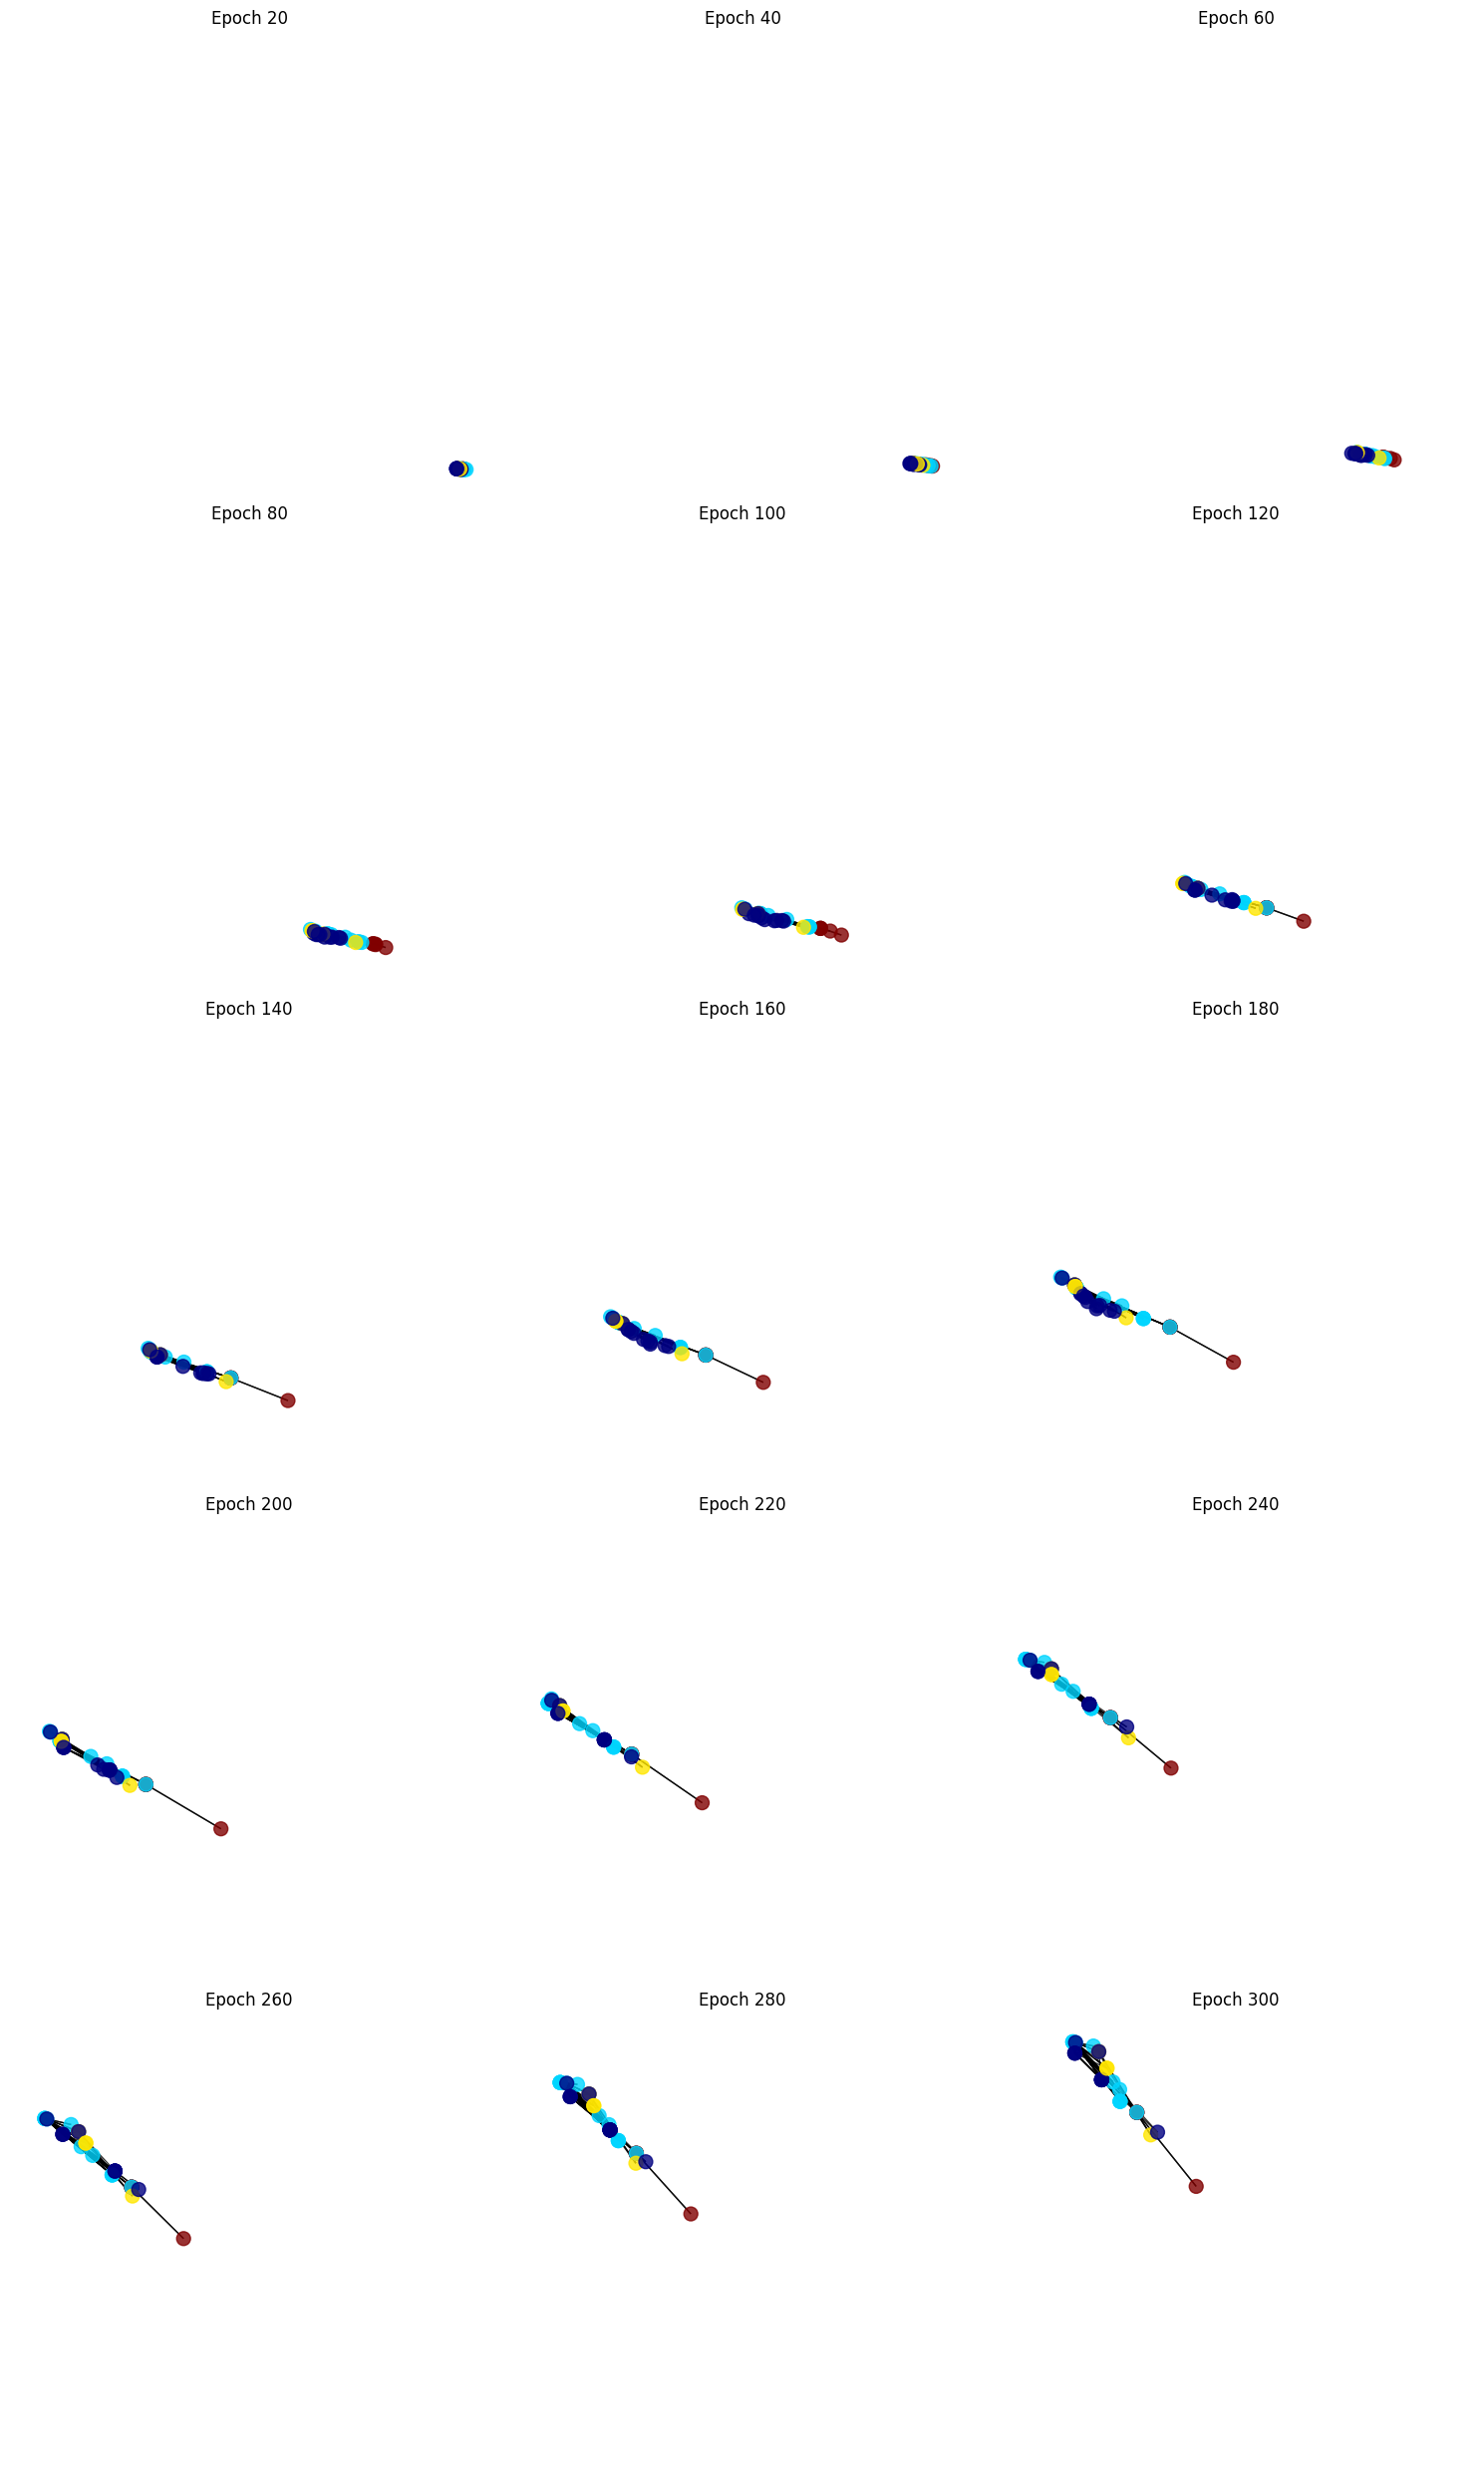


Training and visualization complete.


In [95]:
# --- Model Initialization ---
# Define the architecture of your GAT's attention layers.
# The `num_heads` parameter determines the number of attention heads.
# Each head in the first layers will output `layer_size // num_heads` features.
# The final layer in `layer_sizes` will define the final embedding dimension.
gat_layer_sizes = [64, 32] # Example: Two GAT layers. First outputs 64 features, second 32.
num_attention_heads = 8 # Number of attention heads.

model = GAT(gat_layer_sizes, n_nodes, f_dimension, nb_classes, num_heads=num_attention_heads)
model.compile_model(lr=0.005) # Adjust learning rate if needed

# --- Training and Evaluation Loop ---
outputs = {}
test_outputs = {}

epochs = 300 # GATs might need more epochs to converge
dropout_rate = 0.6 # A common dropout rate for GATs

# Prepare input tensors with an explicit batch dimension (even if batch size is 1)
# Original GAT code used `shape=(None, n_nodes, f_dimension)` for placeholders.
# We mimic that with `tf.expand_dims`.
feat_x_tf = tf.constant(np.expand_dims(feat_x, axis=0), dtype=tf.float32) # Add batch dim
y_train_tf = tf.constant(np.expand_dims(y_train, axis=0), dtype=tf.float32) # Add batch dim
y_test_tf = tf.constant(np.expand_dims(y_test, axis=0), dtype=tf.float32)   # Add batch dim
train_mask_tf = tf.constant(np.expand_dims(train_mask, axis=0), dtype=tf.float32) # Add batch dim
test_mask_tf = tf.constant(np.expand_dims(test_mask, axis=0), dtype=tf.float32)   # Add batch dim
adj_norm_tf = tf.constant(np.expand_dims(adj_norm, axis=0), dtype=tf.float32) # Add batch dim


print("\nStarting GAT training...")
for epoch in range(epochs):
    avg_cost = model.train_step(
        X=feat_x_tf,
        y_true=y_train_tf,
        mask=train_mask_tf,
        adj=adj_norm_tf,
        dropout_rate=dropout_rate
    ).numpy()

    # The accuracy function now returns the first batch's predictions and embeddings
    # since we're using a single batch that represents the whole graph.
    _, train_acc, node_embeddings_2d_train = model.accuracy(
        X=feat_x_tf,
        Y=y_train_tf,
        mask=train_mask_tf,
        adj=adj_norm_tf
    )

    if (epoch + 1) % 20 == 0 or epoch == epochs - 1: # Store less frequently for many epochs
        outputs[epoch + 1] = node_embeddings_2d_train

    _, test_acc, _ = model.accuracy(
        X=feat_x_tf,
        Y=y_test_tf,
        mask=test_mask_tf,
        adj=adj_norm_tf
    )

    if (epoch + 1) % 20 == 0 or epoch == epochs - 1:
        print(f'Epoch: {epoch + 1:04d}, '
              f'cost={avg_cost:.5f}, '
              f'train_acc: {train_acc:.4f}, '
              f'test_acc: {test_acc:.4f}')

# --- Visualization ---
node_labels_for_drawing = data.y.numpy()
model.draw(G, outputs, node_labels=node_labels_for_drawing)

print("\nTraining and visualization complete.")

## Gated Graph Neural Network(GGNN)

We have found that GCN and GAT are CNN-like versions of graph neural networks. GGNN, on the other hand, is the RNN-like version of the node updating method.

First, let's look at the message passing neural network (MPNN) framework. The MPNN framework updates the route node with the following formula. <br>

$$ H_{i}^{(l+1)} = U(H_{i}^{(l)}, m^{(l+1)}) $$

The i-th node, which is a route node, is newly updated through the message state, $m^{(i+1)}$ from the neighboring nodes and previous node state, $H^{(l)}$. <br>

Updating message state can be written as a general formulation as follow.

$$ m^{(l+1)} = \sum_{j \in N_{i}} M(H_i^{(l)}, H_j^{(l)}, e_{ij}) $$

If we know the initial edge information - $e_{ij}$, we can update the message states differently for different relations, for example a single bond, a double bond and an aromatic bond will transfer a different message to the route node. <br>
For simpliticy, we will only consider just connectivity between the node pairs, i.e.) $A_{ij} =1$ for connected node pairs, and zero otherwise.

In GGNN framework, message function is defined as simple summation of the neighbor node states.

$$ m^{(l+1)} = \sum_{j \in N_{i}} H_j^{(l)} $$

And the gated recurrent unit (GRU) is used for the node updating. Finally, the node updating is re-written as follow.

$$ H_i^{(l+1)} = GRU(H_i^{(l)}, \sum_{j \in N_i} H_i^{(l)}) $$

We will implement the updating function in the GGNN framework.

In [96]:
class GGNN:
    def __init__(self, hidden_dim, n_nodes, f_dimension, nb_classes, num_timesteps=4):
        """
        Initializes the Gated Graph Neural Network (GGNN).

        Args:
            hidden_dim (int or list): The dimension of the hidden state (GRU cell output).
                                      If a list, it implies multiple GGNN layers, each with this hidden_dim.
            n_nodes (int): Number of nodes in the graph.
            f_dimension (int): Dimension of input features per node.
            nb_classes (int): Number of output classes.
            num_timesteps (int): Number of message passing steps (iterations) for the GRU.
        """
        self.n_nodes = n_nodes
        self.f_dimension = f_dimension
        self.nb_classes = nb_classes
        self.num_timesteps = num_timesteps

        # Ensure hidden_dim is a list for consistent multi-layer handling
        if not isinstance(hidden_dim, list):
            hidden_dim = [hidden_dim]

        self.hidden_dims = hidden_dim # Hidden dimension for each GGNN layer (if multiple)

        self.ggnn_layers = []
        for i, h_dim in enumerate(self.hidden_dims):
            # Input transformation layer (A * X * W_in)
            self.ggnn_layers.append({
                'input_dense': tf.keras.layers.Dense(units=h_dim, use_bias=True, activation=tf.nn.relu, name=f'ggnn_input_dense_{i}'),
                'gru_cell': tf.keras.layers.GRUCell(units=h_dim, name=f'ggnn_gru_cell_{i}')
            })

        # Final Dense layer for classification
        self.output_layer = tf.keras.layers.Dense(units=self.nb_classes, activation=None, name='output_layer')

        # Layer for projecting the final node embeddings to 2D for visualization
        self.embedding_projection_layer = tf.keras.layers.Dense(units=2, use_bias=True, name='embedding_projection_layer')

    def ggnn_message_passing(self, X_initial, adj, hidden_dim, gru_cell, input_dense_layer):
        """
        Performs iterative message passing for a single GGNN layer.

        Args:
            X_initial (tf.Tensor): Initial node features. Shape: (batch_size, n_nodes, f_dimension)
            adj (tf.Tensor): Adjacency matrix. Shape: (batch_size, n_nodes, n_nodes)
            hidden_dim (int): Hidden dimension for the GRU cell.
            gru_cell (tf.keras.layers.GRUCell): The GRU cell for state updates.
            input_dense_layer (tf.keras.layers.Dense): Dense layer for initial feature transformation.

        Returns:
            tf.Tensor: Final hidden states after `num_timesteps` iterations.
                       Shape: (batch_size, n_nodes, hidden_dim)
        """
        # Initial transformation of input features
        h_t = input_dense_layer(X_initial) # (batch_size, n_nodes, hidden_dim)

        for t in range(self.num_timesteps):
            # 1. Message Aggregation: M_t = A * h_(t-1)
            messages = tf.matmul(adj, h_t) # (batch_size, n_nodes, hidden_dim)

            # 2. Node Update with GRU: h_t = GRU(h_(t-1), M_t)
            # Flatten batch and node dimensions to apply GRU to each node independently across batch.
            flat_messages = tf.reshape(messages, [-1, hidden_dim]) # (batch_size * n_nodes, hidden_dim)
            flat_h_t_prev = tf.reshape(h_t, [-1, hidden_dim])       # (batch_size * n_nodes, hidden_dim)

            # GRUCell's call method expects (inputs, states)
            _, new_states = gru_cell(inputs=flat_messages, states=[flat_h_t_prev])

            # Reshape back to (batch_size, n_nodes, hidden_dim)
            h_t = tf.reshape(new_states, tf.shape(h_t))

        return h_t # Return the final hidden states for this GGNN layer

    def call(self, X, adj, dropout_rate, is_training):
        """Defines the forward pass of the GGNN model."""
        L = X # Initial input features (batch_size, n_nodes, f_dimension)

        for i, layer_params in enumerate(self.ggnn_layers):
            # Apply the GGNN message passing for this layer
            L = self.ggnn_message_passing(
                X_initial=L,
                adj=adj,
                hidden_dim=self.hidden_dims[i],
                gru_cell=layer_params['gru_cell'],
                input_dense_layer=layer_params['input_dense']
            )
            if is_training:
                L = tf.nn.dropout(L, rate=dropout_rate)

        # L now holds the final high-dimensional node embeddings from the last GGNN layer.
        final_node_embeddings = L

        # Project these embeddings to 2D for visualization.
        visual_embeddings = self.embedding_projection_layer(final_node_embeddings)

        # Final classification layer: Multiply by adjacency (as in original) then dense.
        hypothesis = self.output_layer(tf.matmul(adj, final_node_embeddings))

        return hypothesis, visual_embeddings

    def compute_loss(self, y_true, y_pred, mask):
        """Computes the masked softmax cross-entropy loss."""
        # y_true, y_pred: (batch_size, n_nodes, nb_classes)
        # mask: (batch_size, n_nodes)
        cost = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)

        mask = tf.cast(mask, dtype=tf.float32)

        # Reshape mask to (batch_size, n_nodes, 1) to broadcast correctly with cost
        mask_reshaped = tf.expand_dims(mask, axis=-1)

        cost *= mask_reshaped

        # Sum loss over nodes, then average over batch.
        masked_cost_sum_nodes = tf.reduce_sum(cost, axis=[1, 2])

        # Normalize by the number of active nodes in the mask, for each sample.
        num_active_nodes = tf.reduce_sum(mask, axis=1)
        num_active_nodes = tf.where(num_active_nodes == 0, tf.ones_like(num_active_nodes), num_active_nodes)

        per_sample_loss = masked_cost_sum_nodes / num_active_nodes

        return tf.reduce_mean(per_sample_loss) # Average across the batch

    # --- ADDED: compile_model method ---
    def compile_model(self, lr=0.01, optimizer=tf.optimizers.Adam):
        """Configures the model for training."""
        self.optimizer = optimizer(learning_rate=lr)
    # --- END ADDED ---

    @tf.function
    def train_step(self, X, y_true, mask, adj, dropout_rate):
        """Performs a single training step."""
        with tf.GradientTape() as tape:
            y_pred, _ = self.call(X, adj, dropout_rate, is_training=True)
            loss = self.compute_loss(y_true, y_pred, mask)

        trainable_vars = []
        for layer_params in self.ggnn_layers:
            trainable_vars.extend(layer_params['input_dense'].trainable_variables)
            trainable_vars.extend(layer_params['gru_cell'].trainable_variables)
        trainable_vars.extend(self.output_layer.trainable_variables)
        trainable_vars.extend(self.embedding_projection_layer.trainable_variables)

        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        return loss

    def accuracy(self, X, Y, mask, adj):
        """Calculates accuracy with masking."""
        preds, visual_embeddings = self.call(X, adj, dropout_rate=0.0, is_training=False)

        predicted_labels = tf.argmax(preds, axis=2)
        true_labels = tf.argmax(Y, axis=2)

        correct_prediction = tf.equal(predicted_labels, true_labels)
        accuracy_all = tf.cast(correct_prediction, tf.float32)

        mask = tf.cast(mask, dtype=tf.float32)

        masked_correct_sum = tf.reduce_sum(accuracy_all * mask, axis=1)
        num_active_nodes = tf.reduce_sum(mask, axis=1)

        num_active_nodes = tf.where(num_active_nodes == 0, tf.ones_like(num_active_nodes), num_active_nodes)

        per_sample_accuracy = masked_correct_sum / num_active_nodes

        # Return accuracy for the first sample in the batch, and its 2D embeddings.
        return preds[0].numpy(), tf.reduce_mean(per_sample_accuracy).numpy(), visual_embeddings[0].numpy()

    # The draw method remains the same as previous solutions, assuming 2D embeddings are provided.
    def draw(self, g, outputs, node_labels=None):
        """
        Draws the graph embeddings at different epochs, assuming embeddings are already 2D.

        Args:
            g (networkx.Graph): The graph to draw.
            outputs (dict): A dictionary where keys are epoch numbers and values
                            are the node embeddings (numpy array) at that epoch,
                            which are expected to be 2D (N, 2).
            node_labels (dict, optional): A dictionary mapping node IDs to their labels
                                          for coloring. Defaults to None.
        """
        epochs_to_plot = sorted(list(outputs.keys()))

        node_positions = {}
        for epoch in epochs_to_plot:
            embeddings_2d = outputs[epoch]

            if embeddings_2d.shape[1] != 2:
                print(f"Error: Embeddings for epoch {epoch} are not 2D. Shape: {embeddings_2d.shape}")
                print("Please ensure your GGNN model's `embedding_projection_layer` is configured to output 2D embeddings.")
                continue

            node_positions[epoch] = {node_id: embeddings_2d[i]
                                     for i, node_id in enumerate(nx.nodes(g))}

        plot_titles = {o: f'Epoch {o}' for o in node_positions.keys()}

        num_plots = len(node_positions)
        if num_plots == 0:
            print("No valid embeddings to plot. Check `outputs` dictionary and embedding dimensions.")
            return

        nrows = int(np.ceil(num_plots / 3))
        ncols = min(num_plots, 3)

        f, axes = plt.subplots(nrows=nrows, ncols=ncols, sharey=True, sharex=True, figsize=(5 * ncols, 5 * nrows))

        if num_plots == 1:
            axes = np.array([axes])

        epochs_to_plot_successful = sorted(list(node_positions.keys()))

        for i, ax in enumerate(axes.flat):
            if i < num_plots:
                epoch = epochs_to_plot_successful[i]
                pos = node_positions[epoch]
                ax.set_title(plot_titles[epoch])

                node_colors = None

                unique_labels = np.unique(node_labels)
                label_to_int = {label: i for i, label in enumerate(unique_labels)}
                node_colors = [label_to_int[node_labels[n]] for n in nx.nodes(G)]

                nx.draw(
                    g,
                    cmap=plt.get_cmap('jet'),
                    node_color=node_colors,
                    pos=pos,
                    ax=ax,
                    node_size=100,
                    alpha=0.8
                )
            else:
                f.delaxes(ax)

        plt.tight_layout()
        plt.show()


Starting GGNN training...


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['embedding_projection_layer/kernel', 'embedding_projection_layer/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch: 0020, cost=19.40178, train_acc: 0.2500, test_acc: 0.4545
Epoch: 0040, cost=22.48708, train_acc: 0.2500, test_acc: 0.4545
Epoch: 0060, cost=20.45926, train_acc: 0.2500, test_acc: 0.4545
Epoch: 0080, cost=24.60699, train_acc: 0.2500, test_acc: 0.4545
Epoch: 0100, cost=16.08663, train_acc: 0.2500, test_acc: 0.4545
Epoch: 0120, cost=19.98190, train_acc: 0.2500, test_acc: 0.4545
Epoch: 0140, cost=19.60833, train_acc: 0.2500, test_acc: 0.4545
Epoch: 0160, cost=17.28541, train_acc: 0.2500, test_acc: 0.4545
Epoch: 0180, cost=18.44930, train_acc: 0.2500, test_acc: 0.4545
Epoch: 0200, cost=16.07928, train_acc: 0.2500, test_acc: 0.4545
Epoch: 0220, cost=21.79859, train_acc: 0.2500, test_acc: 0.4545
Epoch: 0240, cost=18.08214, train_acc: 0.2500, test_acc: 0.4545
Epoch: 0260, cost=16.19097, train_acc: 0.2500, test_acc: 0.4545
Epoch: 0280, cost=19.76936, train_acc: 0.2500, test_acc: 0.4545
Epoch: 0300, cost=17.30023, train_acc: 0.2500, test_acc: 0.4545


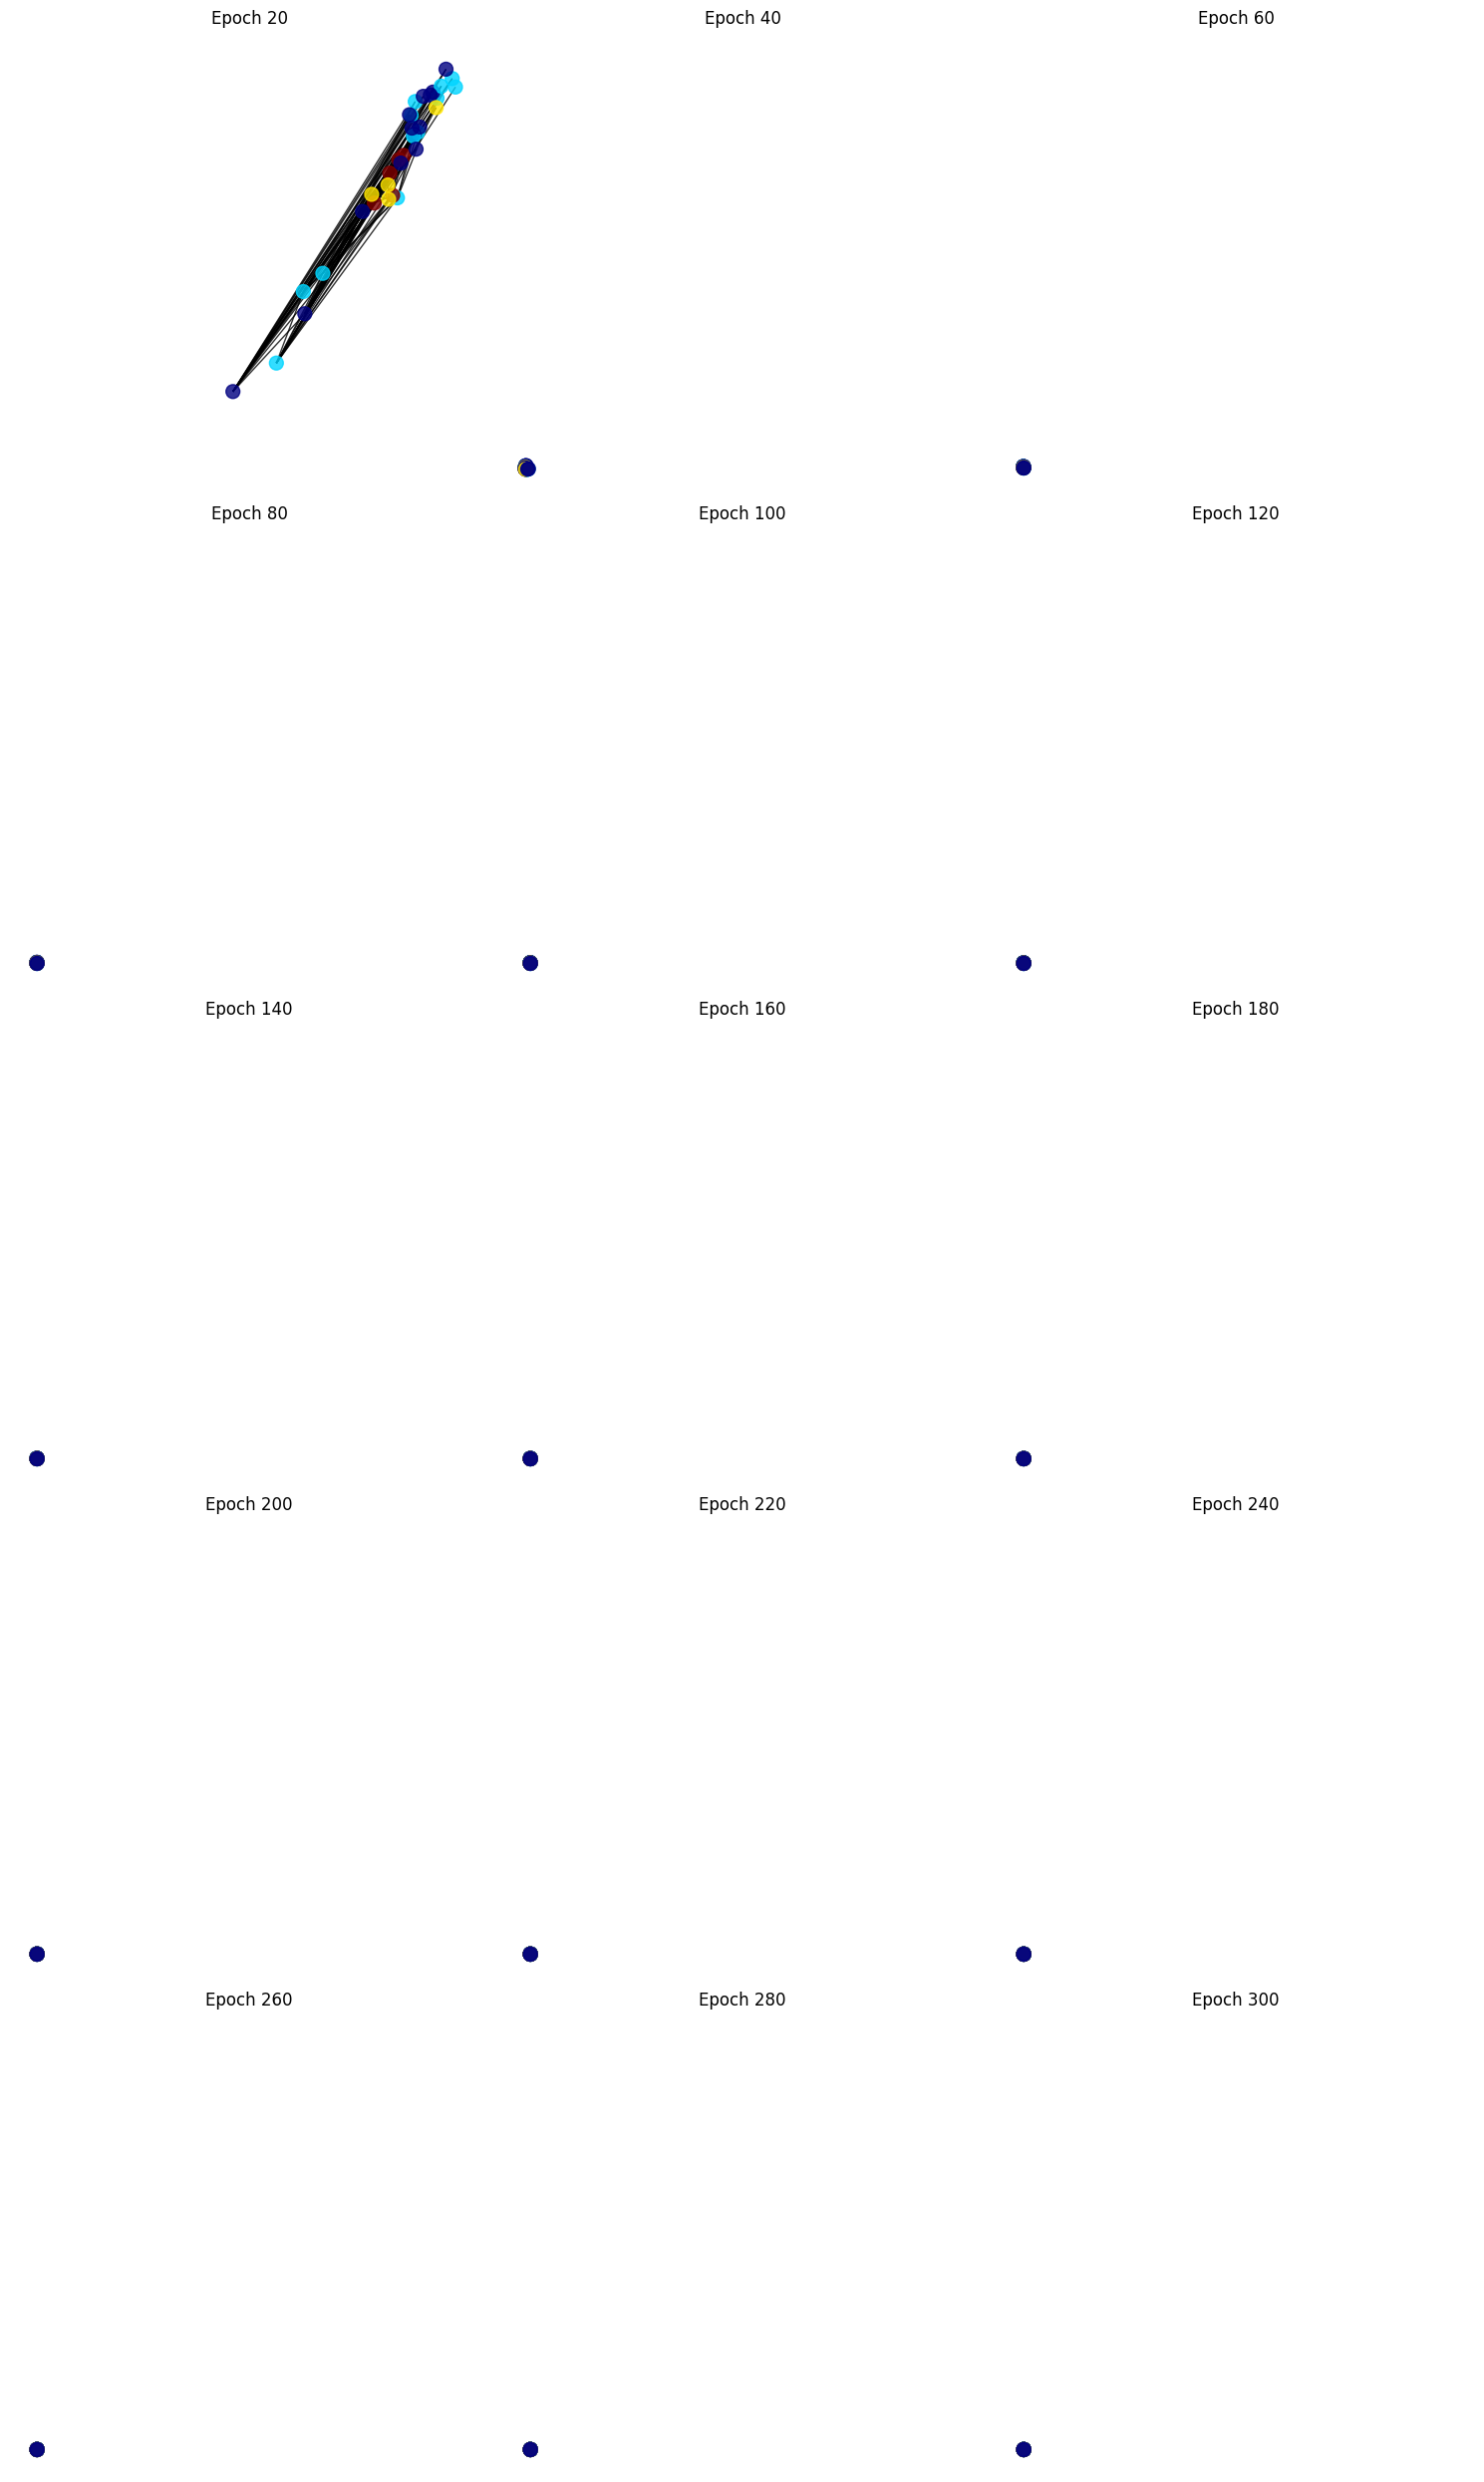


Training and visualization complete.


In [97]:
# --- Model Initialization ---
# Define the hidden dimension for the GRU cell in the GGNN layer(s).
# If you want multiple GGNN layers, pass a list, e.g., [64, 32].
# Here, we use a single GGNN layer with a hidden dimension of 32.
ggnn_hidden_dim = 32
num_message_passing_steps = 5 # Number of times the GRU cell updates its state.

model = GGNN(
    hidden_dim=ggnn_hidden_dim,
    n_nodes=n_nodes,
    f_dimension=f_dimension,
    nb_classes=nb_classes,
    num_timesteps=num_message_passing_steps
)
model.compile_model(lr=0.005) # Adjust learning rate if needed.

# --- Training and Evaluation Loop ---
outputs = {}
test_outputs = {}

epochs = 300 # GGNNs might also need a good number of epochs.
dropout_rate = 0.5 # Dropout rate after each GGNN layer.

# Prepare input tensors with an explicit batch dimension.
feat_x_tf = tf.constant(np.expand_dims(feat_x, axis=0), dtype=tf.float32)
y_train_tf = tf.constant(np.expand_dims(y_train, axis=0), dtype=tf.float32)
y_test_tf = tf.constant(np.expand_dims(y_test, axis=0), dtype=tf.float32)
train_mask_tf = tf.constant(np.expand_dims(train_mask, axis=0), dtype=tf.float32)
test_mask_tf = tf.constant(np.expand_dims(test_mask, axis=0), dtype=tf.float32)
adj_norm_tf = tf.constant(np.expand_dims(adj_norm, axis=0), dtype=tf.float32)


print("\nStarting GGNN training...")
for epoch in range(epochs):
    avg_cost = model.train_step(
        X=feat_x_tf,
        y_true=y_train_tf,
        mask=train_mask_tf,
        adj=adj_norm_tf,
        dropout_rate=dropout_rate
    ).numpy()

    _, train_acc, node_embeddings_2d_train = model.accuracy(
        X=feat_x_tf,
        Y=y_train_tf,
        mask=train_mask_tf,
        adj=adj_norm_tf
    )

    if (epoch + 1) % 20 == 0 or epoch == epochs - 1:
        outputs[epoch + 1] = node_embeddings_2d_train

    _, test_acc, _ = model.accuracy(
        X=feat_x_tf,
        Y=y_test_tf,
        mask=test_mask_tf,
        adj=adj_norm_tf
    )

    if (epoch + 1) % 20 == 0 or epoch == epochs - 1:
        print(f'Epoch: {epoch + 1:04d}, '
              f'cost={avg_cost:.5f}, '
              f'train_acc: {train_acc:.4f}, '
              f'test_acc: {test_acc:.4f}')

# --- Visualization ---
node_labels_for_drawing = data.y.numpy()
model.draw(G, outputs, node_labels=node_labels_for_drawing)

print("\nTraining and visualization complete.")

## Gated Attention Graph Neural Netoworks

* Ryu, Seongok, Jaechang Lim, and Woo Youn Kim. "Deeply learning molecular structure-property relationships using graph attention neural network." arXiv preprint arXiv:1805.10988 (2018).


 Here, we need to take one more fact into account when using the GCN. Performing multiple graph convolutions enables the model to carry over information from distant atoms. Kipf and Welling reported effects of the model depth for GCN.47 Without the skipconnection, they could not train models with more than 7 graph convolution layers. Although using the skip-connection allowed them to achieve deeper models, accuracy of the models was gradually lowered as the number of convolution layers increases. We also observed the similar results (see in Fig. 3(a)). To avoid the aforementioned problems, which is related to the second missing term, we propose a gated skip-connection. The concept of gate is used in recurrent cell units such as the gated recurrentunit(GRU)45 andthelong-shorttermmemory(LSTM)55. When a model updates sequential hidden states, the gate is used to deliver previous information accurately by determining forget and update rates. Inspired from the gate mechanism in the recurrent cell units, we adopt the gate in using the skip-connection.

This class looks like a hybrid of GAT and GGNN, particularly in its ggnn function which seems to apply a GRU-like update, and its attn_coeffs which computes attention. The original loss method calls self.ggnn repeatedly, which is a bit unusual for a GAGN; typically, attention is applied within or before the GRU update in such models. The attn_coeffs function itself has some complex reshaping and a mysterious tf.zeros(shape=(D*2, 1)) multiplication, implying it's not a standard attention mechanism as commonly seen in GATs (where it's usually a^T [W_i x_i || W_j x_j]

In [98]:
class GAGN:
    def __init__(self, hidden_dim, n_nodes, f_dimension, nb_classes, num_timesteps=4, attn_heads=1):
        """
        Initializes the Graph Attention Gated Network (GAGN).
        Combines aspects of GAT (attention) and GGNN (GRU-based propagation).

        Args:
            hidden_dim (int or list): Dimension of the hidden state (GRU cell output).
                                      If a list, defines dimensions for multiple GAGN layers.
            n_nodes (int): Number of nodes in the graph.
            f_dimension (int): Dimension of input features per node.
            nb_classes (int): Number of output classes.
            num_timesteps (int): Number of message passing steps (iterations) for the GRU.
            attn_heads (int): Number of attention heads. For simplicity, set to 1 for this GAGN.
                              Multi-head attention would make the `attn_coeffs` more complex.
        """
        self.n_nodes = n_nodes
        self.f_dimension = f_dimension
        self.nb_classes = nb_classes
        self.num_timesteps = num_timesteps
        self.attn_heads = attn_heads # Keeping it simple with single attention head for now

        if not isinstance(hidden_dim, list):
            hidden_dim = [hidden_dim]
        self.hidden_dims = hidden_dim

        self.gag_layers = []
        for i, h_dim in enumerate(self.hidden_dims):
            # Input transformation layer (similar to the GAT's initial dense layer for node features)
            input_dense = tf.keras.layers.Dense(units=h_dim, use_bias=True, name=f'gagn_input_dense_{i}')

            # Layers for attention coefficients (similar to GAT's f_1, f_2 logic)
            # We'll concatenate transformed features, then apply a dense layer.
            attn_dense = tf.keras.layers.Dense(units=1, use_bias=True, name=f'gagn_attn_dense_{i}')

            # GRU cell for state updates
            gru_cell = tf.keras.layers.GRUCell(units=h_dim, name=f'gagn_gru_cell_{i}')

            self.gag_layers.append({
                'input_dense': input_dense,
                'attn_dense': attn_dense,
                'gru_cell': gru_cell
            })

        # Final Dense layer for classification
        self.output_layer = tf.keras.layers.Dense(units=self.nb_classes, activation=None, name='output_layer')

        # Layer for projecting the final node embeddings to 2D for visualization
        self.embedding_projection_layer = tf.keras.layers.Dense(units=2, use_bias=True, name='embedding_projection_layer')

    def attn_coeffs(self, H, adj_matrix, active=tf.nn.leaky_relu):
        """
        Calculates attention coefficients, incorporating adjacency.
        Similar to GAT, but simplified for a single head and directly using H.

        Args:
            H (tf.Tensor): Node embeddings (hidden states). Shape: (batch_size, N, D)
            adj_matrix (tf.Tensor): Adjacency matrix. Shape: (batch_size, N, N)
            active (callable): Activation function (e.g., tf.nn.leaky_relu).

        Returns:
            tf.Tensor: Attention coefficients matrix. Shape: (batch_size, N, N)
        """
        B, N, D = H.shape.as_list()

        # Create pairs of (h_i, h_j) for all i, j
        # tile H to (B, N, N, D) for h_i
        Hi_tiled = tf.tile(tf.expand_dims(H, axis=2), [1, 1, N, 1])
        # tile H to (B, N, N, D) for h_j
        Hj_tiled = tf.tile(tf.expand_dims(H, axis=1), [1, N, 1, 1])

        # Concatenate (h_i || h_j) features for attention scoring
        a_input = tf.concat([Hi_tiled, Hj_tiled], axis=-1) # (B, N, N, 2*D)

        # Apply a dense layer to get attention scores (e_ij)
        # Using a shared dense layer across all (i,j) pairs.
        # This is `a^T [W_k * h_i || W_k * h_j]` in GAT formulation.
        # Here we directly use the concatenated features.
        e = self.gag_layers[0]['attn_dense'](a_input) # (B, N, N, 1)
        e = tf.squeeze(e, axis=-1) # (B, N, N)

        e = active(e, alpha=0.2) # Apply Leaky ReLU

        # Mask attention coefficients based on adjacency matrix
        # Non-connected nodes get a very small negative value before softmax
        zero_vec = -9e15 * tf.ones_like(e)
        attention_masked = tf.where(adj_matrix > 0, e, zero_vec)

        # Apply softmax to get attention coefficients (alpha_ij)
        coefs = tf.nn.softmax(attention_masked, axis=-1) # Softmax over last dimension (neighbors)
        return coefs

    def gagn_message_passing(self, X_initial, adj, hidden_dim, gru_cell, input_dense_layer, attn_dense_layer, dropout_rate, is_training):
        """
        Performs iterative message passing for a single GAGN layer,
        incorporating attention into the message aggregation.

        Args:
            X_initial (tf.Tensor): Initial node features/hidden states. Shape: (batch_size, n_nodes, f_dimension/prev_hidden_dim)
            adj (tf.Tensor): Adjacency matrix. Shape: (batch_size, n_nodes, n_nodes)
            hidden_dim (int): Hidden dimension for the GRU cell.
            gru_cell (tf.keras.layers.GRUCell): The GRU cell for state updates.
            input_dense_layer (tf.keras.layers.Dense): Dense layer for initial feature transformation.
            attn_dense_layer (tf.keras.layers.Dense): Dense layer for attention score calculation.
            dropout_rate (float): Dropout rate.
            is_training (bool): Whether in training mode.

        Returns:
            tf.Tensor: Final hidden states after `num_timesteps` iterations.
                       Shape: (batch_size, n_nodes, hidden_dim)
        """
        # Initial transformation of input features to the hidden_dim
        h_t = input_dense_layer(X_initial) # (batch_size, n_nodes, hidden_dim)

        for t in range(self.num_timesteps):
            # 1. Calculate Attention Coefficients
            # The current hidden state `h_t` is used to calculate attention
            # (Note: self.attn_coeffs needs access to the current layer's attn_dense_layer.
            # A cleaner way would be to pass self or restructure `attn_coeffs` as a method of a layer.)
            # For simplicity, I'm using the first layer's attn_dense_layer in attn_coeffs
            # This needs to be refined if you want layer-specific attention weights.
            # A more robust GAGN would have attn_dense_layer part of the GRUCell or a custom layer.

            # For this context, I'll pass the current layer's attn_dense to attn_coeffs.
            # Temporarily modify attn_coeffs to take attn_dense as an arg.
            # Better: make attn_coeffs a method of the specific GAGN layer.

            # --- Inline Attention Calculation (Simplified for this rewrite) ---
            B, N, D = h_t.shape.as_list()
            Hi_tiled = tf.tile(tf.expand_dims(h_t, axis=2), [1, 1, N, 1])
            Hj_tiled = tf.tile(tf.expand_dims(h_t, axis=1), [1, N, 1, 1])
            a_input = tf.concat([Hi_tiled, Hj_tiled], axis=-1) # (B, N, N, 2*D)
            e = attn_dense_layer(a_input) # Use the current layer's attn_dense
            e = tf.squeeze(e, axis=-1)
            e = tf.nn.leaky_relu(e, alpha=0.2)

            zero_vec = -9e15 * tf.ones_like(e)
            attention_masked = tf.where(adj > 0, e, zero_vec)
            attention_coefs = tf.nn.softmax(attention_masked, axis=-1) # Softmax over neighbors

            if is_training:
                attention_coefs = tf.nn.dropout(attention_coefs, rate=dropout_rate)
            # --- End Inline Attention Calculation ---

            # 2. Message Aggregation: M_t = Attention_Coefs * h_(t-1)
            # Messages are weighted by attention coefficients.
            messages = tf.matmul(attention_coefs, h_t) # (batch_size, n_nodes, hidden_dim)

            # 3. Node Update with GRU: h_t = GRU(h_(t-1), M_t)
            flat_messages = tf.reshape(messages, [-1, hidden_dim])
            flat_h_t_prev = tf.reshape(h_t, [-1, hidden_dim])

            _, new_states = gru_cell(inputs=flat_messages, states=[flat_h_t_prev])

            h_t = tf.reshape(new_states, tf.shape(h_t))

        return h_t # Return the final hidden states for this GAGN layer

    def call(self, X, adj, dropout_rate, is_training):
        """Defines the forward pass of the GAGN model."""
        L = X # Initial input features (batch_size, n_nodes, f_dimension)

        for i, layer_params in enumerate(self.gag_layers):
            L = self.gagn_message_passing(
                X_initial=L,
                adj=adj,
                hidden_dim=self.hidden_dims[i],
                gru_cell=layer_params['gru_cell'],
                input_dense_layer=layer_params['input_dense'],
                attn_dense_layer=layer_params['attn_dense'], # Pass attn_dense for this layer
                dropout_rate=dropout_rate,
                is_training=is_training
            )
            # The original code applied dropout after each GGNN layer outside the loop.
            # I've moved it into the `gagn_message_passing` to apply to attention.
            # If you want it applied to the final `L` after the message passing, add it here.
            # if is_training:
            #     L = tf.nn.dropout(L, rate=dropout_rate)


        # L now holds the final high-dimensional node embeddings.
        final_node_embeddings = L

        # Project these embeddings to 2D for visualization.
        visual_embeddings = self.embedding_projection_layer(final_node_embeddings)

        # Final classification layer: Multiply by adjacency then dense, as in original.
        hypothesis = self.output_layer(tf.matmul(adj, final_node_embeddings))

        return hypothesis, visual_embeddings

    def compute_loss(self, y_true, y_pred, mask):
        """Computes the masked softmax cross-entropy loss."""
        cost = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)

        mask = tf.cast(mask, dtype=tf.float32)
        mask_reshaped = tf.expand_dims(mask, axis=-1)
        cost *= mask_reshaped

        masked_cost_sum_nodes = tf.reduce_sum(cost, axis=[1, 2])
        num_active_nodes = tf.reduce_sum(mask, axis=1)
        num_active_nodes = tf.where(num_active_nodes == 0, tf.ones_like(num_active_nodes), num_active_nodes)

        per_sample_loss = masked_cost_sum_nodes / num_active_nodes

        return tf.reduce_mean(per_sample_loss)

    def compile_model(self, lr=0.01, optimizer=tf.optimizers.Adam):
        """Configures the model for training."""
        self.optimizer = optimizer(learning_rate=lr)

    @tf.function
    def train_step(self, X, y_true, mask, adj, dropout_rate):
        """Performs a single training step."""
        with tf.GradientTape() as tape:
            y_pred, _ = self.call(X, adj, dropout_rate, is_training=True)
            loss = self.compute_loss(y_true, y_pred, mask)

        trainable_vars = []
        for layer_params in self.gag_layers:
            trainable_vars.extend(layer_params['input_dense'].trainable_variables)
            trainable_vars.extend(layer_params['attn_dense'].trainable_variables) # Include attn_dense vars
            trainable_vars.extend(layer_params['gru_cell'].trainable_variables)
        trainable_vars.extend(self.output_layer.trainable_variables)
        trainable_vars.extend(self.embedding_projection_layer.trainable_variables)

        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        return loss

    def accuracy(self, X, Y, mask, adj):
        """Calculates accuracy with masking."""
        preds, visual_embeddings = self.call(X, adj, dropout_rate=0.0, is_training=False)

        predicted_labels = tf.argmax(preds, axis=2)
        true_labels = tf.argmax(Y, axis=2)

        correct_prediction = tf.equal(predicted_labels, true_labels)
        accuracy_all = tf.cast(correct_prediction, tf.float32)

        mask = tf.cast(mask, dtype=tf.float32)

        masked_correct_sum = tf.reduce_sum(accuracy_all * mask, axis=1)
        num_active_nodes = tf.reduce_sum(mask, axis=1)

        num_active_nodes = tf.where(num_active_nodes == 0, tf.ones_like(num_active_nodes), num_active_nodes)

        per_sample_accuracy = masked_correct_sum / num_active_nodes

        return preds[0].numpy(), tf.reduce_mean(per_sample_accuracy).numpy(), visual_embeddings[0].numpy()

    # The draw method remains the same
    def draw(self, g, outputs, node_labels=None):
        """
        Draws the graph embeddings at different epochs, assuming embeddings are already 2D.

        Args:
            g (networkx.Graph): The graph to draw.
            outputs (dict): A dictionary where keys are epoch numbers and values
                            are the node embeddings (numpy array) at that epoch,
                            which are expected to be 2D (N, 2).
            node_labels (dict, optional): A dictionary mapping node IDs to their labels
                                          for coloring. Defaults to None.
        """
        epochs_to_plot = sorted(list(outputs.keys()))

        node_positions = {}
        for epoch in epochs_to_plot:
            embeddings_2d = outputs[epoch]

            if embeddings_2d.shape[1] != 2:
                print(f"Error: Embeddings for epoch {epoch} are not 2D. Shape: {embeddings_2d.shape}")
                print("Please ensure your GAGN model's `embedding_projection_layer` is configured to output 2D embeddings.")
                continue

            node_positions[epoch] = {node_id: embeddings_2d[i]
                                     for i, node_id in enumerate(nx.nodes(g))}

        plot_titles = {o: f'Epoch {o}' for o in node_positions.keys()}

        num_plots = len(node_positions)
        if num_plots == 0:
            print("No valid embeddings to plot. Check `outputs` dictionary and embedding dimensions.")
            return

        nrows = int(np.ceil(num_plots / 3))
        ncols = min(num_plots, 3)

        f, axes = plt.subplots(nrows=nrows, ncols=ncols, sharey=True, sharex=True, figsize=(5 * ncols, 5 * nrows))

        if num_plots == 1:
            axes = np.array([axes])

        epochs_to_plot_successful = sorted(list(node_positions.keys()))

        for i, ax in enumerate(axes.flat):
            if i < num_plots:
                epoch = epochs_to_plot_successful[i]
                pos = node_positions[epoch]
                ax.set_title(plot_titles[epoch])

                node_colors = None

                unique_labels = np.unique(node_labels)
                label_to_int = {label: i for i, label in enumerate(unique_labels)}
                node_colors = [label_to_int[node_labels[n]] for n in nx.nodes(G)]

                nx.draw(
                    g,
                    cmap=plt.get_cmap('jet'),
                    node_color=node_colors,
                    pos=pos,
                    ax=ax,
                    node_size=100,
                    alpha=0.8
                )
            else:
                f.delaxes(ax)

        plt.tight_layout()
        plt.show()


Starting GAGN training...
Epoch: 0020, cost=16.62274, train_acc: 0.2500, test_acc: 0.0455
Epoch: 0040, cost=17.02520, train_acc: 0.2500, test_acc: 0.0455
Epoch: 0060, cost=16.88755, train_acc: 0.2500, test_acc: 0.0455
Epoch: 0080, cost=16.91067, train_acc: 0.2500, test_acc: 0.0455
Epoch: 0100, cost=16.89929, train_acc: 0.2500, test_acc: 0.0455
Epoch: 0120, cost=16.89976, train_acc: 0.2500, test_acc: 0.0455
Epoch: 0140, cost=16.89684, train_acc: 0.2500, test_acc: 0.0455
Epoch: 0160, cost=16.89677, train_acc: 0.2500, test_acc: 0.0455
Epoch: 0180, cost=16.89418, train_acc: 0.2500, test_acc: 0.0455
Epoch: 0200, cost=16.89325, train_acc: 0.2500, test_acc: 0.0455
Epoch: 0220, cost=16.89204, train_acc: 0.2500, test_acc: 0.0455
Epoch: 0240, cost=16.89100, train_acc: 0.2500, test_acc: 0.0455
Epoch: 0260, cost=16.89023, train_acc: 0.2500, test_acc: 0.0455
Epoch: 0280, cost=16.88951, train_acc: 0.2500, test_acc: 0.0455
Epoch: 0300, cost=16.88882, train_acc: 0.2500, test_acc: 0.0455


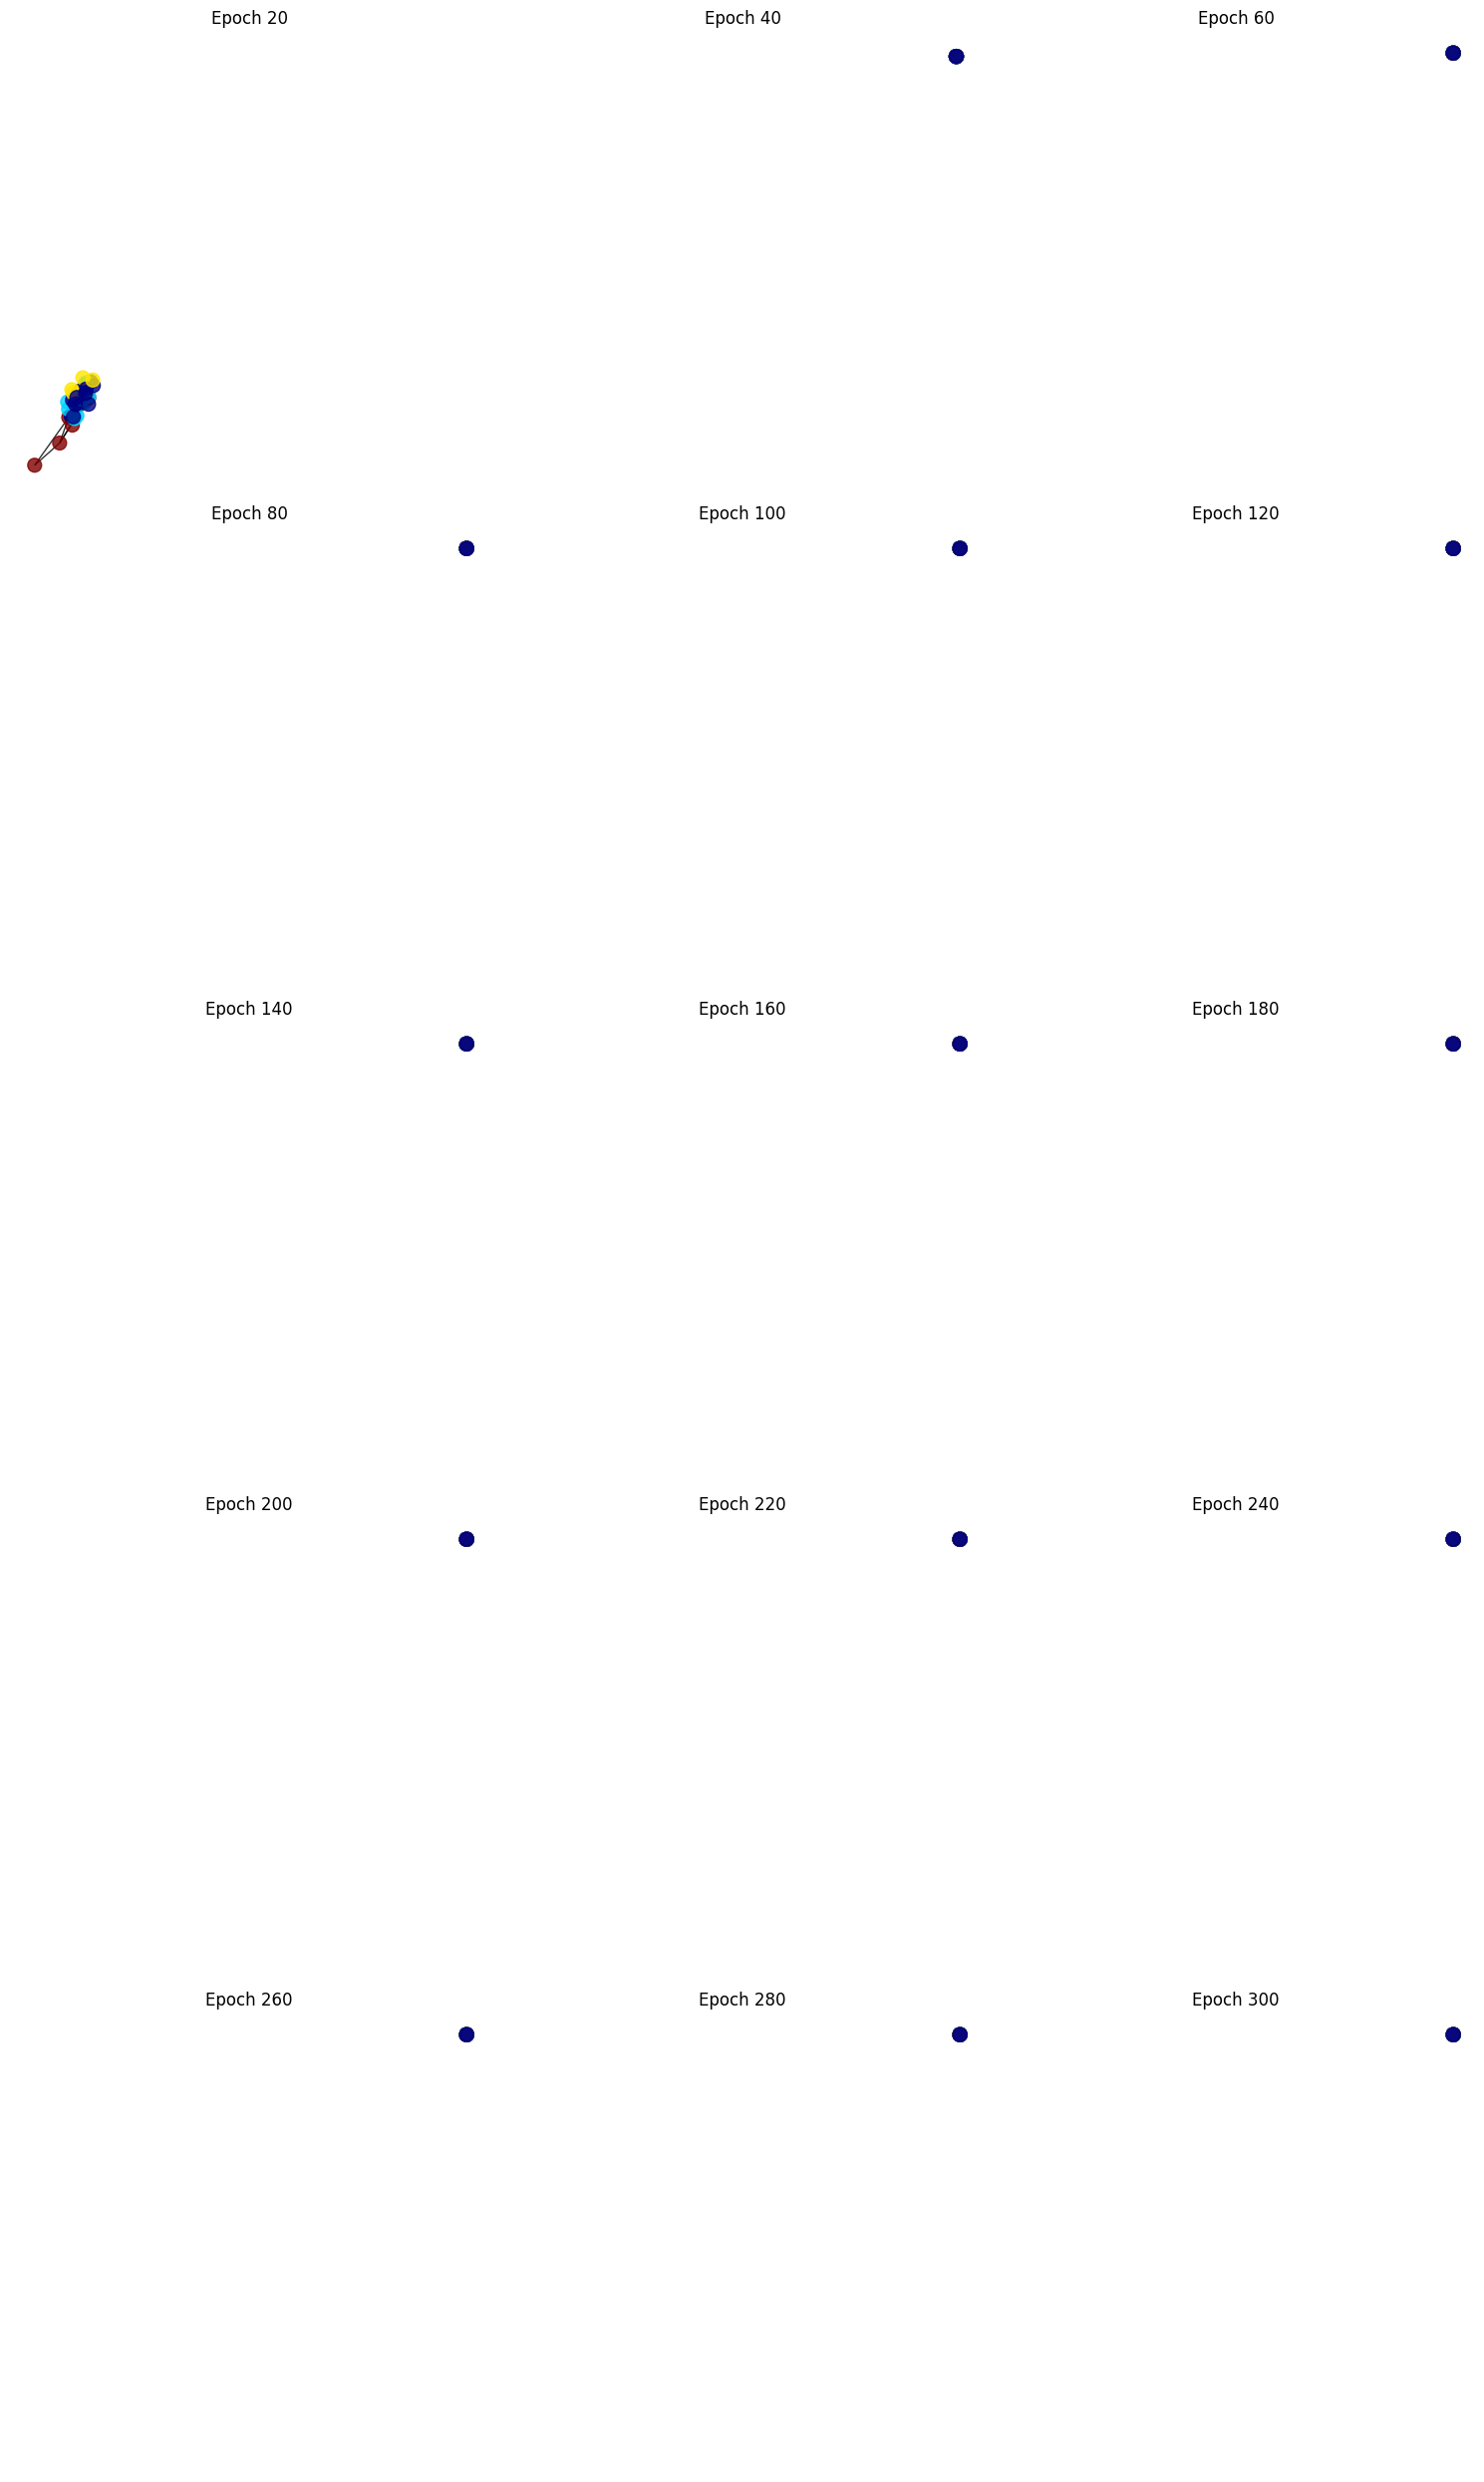


Training and visualization complete.


In [99]:
# --- Model Initialization ---
# Define the hidden dimension for the GRU cell in the GAGN layer(s).
# You can pass a list for multiple GAGN layers, e.g., [64, 32].
gag_hidden_dim = 32
num_message_passing_steps = 5 # Number of times the GRU cell updates its state.
num_attention_heads = 1 # Keeping it simple with 1 attention head for this version

model = GAGN(
    hidden_dim=gag_hidden_dim,
    n_nodes=n_nodes,
    f_dimension=f_dimension,
    nb_classes=nb_classes,
    num_timesteps=num_message_passing_steps,
    attn_heads=num_attention_heads
)
model.compile_model(lr=0.005) # Adjust learning rate if needed.

# --- Training and Evaluation Loop ---
outputs = {}
test_outputs = {}

epochs = 300 # Might need more epochs for complex models
dropout_rate = 0.5 # Dropout rate.

# Prepare input tensors with an explicit batch dimension.
feat_x_tf = tf.constant(np.expand_dims(feat_x, axis=0), dtype=tf.float32)
y_train_tf = tf.constant(np.expand_dims(y_train, axis=0), dtype=tf.float32)
y_test_tf = tf.constant(np.expand_dims(y_test, axis=0), dtype=tf.float32)
train_mask_tf = tf.constant(np.expand_dims(train_mask, axis=0), dtype=tf.float32)
test_mask_tf = tf.constant(np.expand_dims(test_mask, axis=0), dtype=tf.float32)
adj_norm_tf = tf.constant(np.expand_dims(adj_norm, axis=0), dtype=tf.float32)


print("\nStarting GAGN training...")
for epoch in range(epochs):
    avg_cost = model.train_step(
        X=feat_x_tf,
        y_true=y_train_tf,
        mask=train_mask_tf,
        adj=adj_norm_tf,
        dropout_rate=dropout_rate
    ).numpy()

    _, train_acc, node_embeddings_2d_train = model.accuracy(
        X=feat_x_tf,
        Y=y_train_tf,
        mask=train_mask_tf,
        adj=adj_norm_tf
    )

    if (epoch + 1) % 20 == 0 or epoch == epochs - 1:
        outputs[epoch + 1] = node_embeddings_2d_train

    _, test_acc, _ = model.accuracy(
        X=feat_x_tf,
        Y=y_test_tf,
        mask=test_mask_tf,
        adj=adj_norm_tf
    )

    if (epoch + 1) % 20 == 0 or epoch == epochs - 1:
        print(f'Epoch: {epoch + 1:04d}, '
              f'cost={avg_cost:.5f}, '
              f'train_acc: {train_acc:.4f}, '
              f'test_acc: {test_acc:.4f}')

# --- Visualization ---
node_labels_for_drawing = data.y.numpy()
model.draw(G, outputs, node_labels=node_labels_for_drawing)

print("\nTraining and visualization complete.")

# Existing node prediction

In [101]:
# Assuming 'model' is your trained GAGN instance, and
# 'feat_x_tf' and 'adj_norm_tf' are your batched input features and adjacency.

# Make sure to run in inference mode: dropout_rate=0.0, is_training=False
# The `call` method returns (hypothesis, visual_embeddings)
# hypothesis: (1, n_nodes, nb_classes)
# visual_embeddings: (1, n_nodes, 2)
predictions_full_graph, _ = model.call(
    X=feat_x_tf,
    adj=adj_norm_tf,
    dropout_rate=0.0, # No dropout during inference
    is_training=False # Set to False for inference
)

# Convert predictions to NumPy for easier handling
predictions_full_graph_np = predictions_full_graph.numpy() # Shape: (1, n_nodes, nb_classes)

# Since we have a batch size of 1 (because we process the whole graph at once),
# remove the batch dimension.
predictions_per_node = predictions_full_graph_np[0] # Shape: (n_nodes, nb_classes)

# Now, predictions_per_node contains the class probabilities for every node.
# To get the predicted class label for a specific node (e.g., node with index 0):
node_index_to_predict = 0 # Example: Let's pick node 0

# Get the probabilities for node 0
probabilities_node_0 = predictions_per_node[node_index_to_predict]

# Get the predicted class (index with highest probability)
predicted_class_node_0 = np.argmax(probabilities_node_0)

print(f"\n--- Node Prediction Example (Node Index: {node_index_to_predict}) ---")
print(f"Probabilities for node {node_index_to_predict}: {probabilities_node_0}")
print(f"Predicted class for node {node_index_to_predict}: {predicted_class_node_0}")

# You can repeat this for any node index:
random_node_indices = np.random.choice(n_nodes, size=5, replace=False) # Pick 5 random nodes
print(f"\n--- Predictions for Random Nodes ---")
for node_idx in random_node_indices:
    node_probabilities = predictions_per_node[node_idx]
    node_predicted_class = np.argmax(node_probabilities)
    print(f"Node {node_idx}: Predicted class {node_predicted_class} (Probs: {node_probabilities})")

# To get the actual label (if available) for comparison
node_id_list = list(G.nodes()) # Get list of NetworkX node IDs in order
actual_faction = node_labels_for_drawing[node_id_list[node_index_to_predict]] -1 # -1 if your labels are 1-indexed factions
print(f"Actual class for node {node_index_to_predict}: {actual_faction}")


--- Node Prediction Example (Node Index: 0) ---
Probabilities for node 0: [-97.87611 -97.4496  -96.31656 -97.54521]
Predicted class for node 0: 2

--- Predictions for Random Nodes ---
Node 4: Predicted class 2 (Probs: [-44.986057 -44.821045 -44.33837  -44.854527])
Node 3: Predicted class 2 (Probs: [-53.476315 -53.269318 -52.68225  -53.31278 ])
Node 31: Predicted class 2 (Probs: [-52.74563  -52.542244 -51.964157 -52.584843])
Node 0: Predicted class 2 (Probs: [-97.87611 -97.4496  -96.31656 -97.54521])
Node 28: Predicted class 2 (Probs: [-37.908497 -37.778465 -37.38283  -37.80364 ])
Actual class for node 0: 0
